### Библиотеки

In [2]:
import math
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from random import random
from scipy.stats import norm, uniform, expon, bernoulli
from scipy import stats
from typing import Dict, List, Tuple, Callable

from statsmodels.stats.weightstats import ztest, ttest_ind
from scipy.stats import chi2_contingency, fisher_exact
from scipy.stats import norm, expon, t, hypergeom, chi2

import warnings
warnings.filterwarnings("ignore")

### Метрики и Доверительные интервалы

В лекция мы уже упоминали о “практической” проблеме A/B-аналитики: метрику посчитать обычно легко, а вот **правильно оценить её неопределённость** — не всегда. Когда метрика устроена как среднее (value-метрика), всё выглядит почти честно и прозрачно: есть ЦПТ, есть стандартная ошибка, есть привычный доверительный интервал. Но реальный мир быстро подсовывает метрики посложнее: **отношения** (конверсии, CTR, trips per hour), **uplift’ы** (доля, делённая на долю), **перцентили** (95-й, 99-й), а иногда ещё и данные на уровне событий, где внутри пользователя всё зависимо. И вот тут “взять дисперсию как у среднего” уже нельзя: метрика становится **нелинейной** функцией от случайных величин, и наивные формулы либо дают смещённую оценку, либо — что хуже — уверенно рисуют слишком узкие интервалы, создавая ложную уверенность в эффекте.

В этом блоке мы как раз поговорим про то, как аккуратно разрулить эту ситуацию. Мы начнём с того, чтобы зафиксировать, какие вообще бывают типы метрик в экспериментах и почему к ним нельзя подходить “одним ключом”. Затем разберём главный рабочий инструмент, который позволяет превратить сложную метрику в задачу про почти-линейные приближения, — **дельта-метод**. Смысл у него очень человеческий: если функция гладкая, то локально она ведёт себя почти как прямая, а значит можно понять, как шум во входных оценках “проталкивается” в шум метрики на выходе. Именно это и даёт нам формулы для дисперсий и, как следствие, доверительных интервалов там, где готовых “в учебнике” нет.

Дальше мы шаг за шагом выведем и закрепим на примерах, как строятся **оценки и доверительные интервалы** для разных классов метрик: для value-метрик (absolute и uplift), для ratio-метрик (в одной группе и в A/B), а также для перцентилей — включая важный случай, когда данные на уровне событий и нужно помнить про кластеризацию по пользователю. В итоге у нас получится понятная карта: **какую статистику считаем, какую дисперсию оцениваем, и какой доверительный интервал получаем** — без “магии”, с ясной логикой каждого шага.


#### Цетральная Предельная Теорема

Предположим, мы проводим A/B-тестирование и измеряем две метрики для вариантов A и B: коэффициент конверсии C (с какой скоростью люди совершают конверсию) и затраченное время T (сколько минут они проводят в продукте). В обоих случаях наша нулевая гипотеза будет «A и B — одно и то же», что можно перевести на язык математики следующим образом:

$
H_0 (конверсия):  \text{Conv}_A=\text{Conv}_B \\
H_0 (время): \text{Time}_A=\text{Time}_B
$


Здесь важный момент: в приведенном выше выражении $\text{Conv}_A$ и $\text{Conv}_B$— коэффициент конверсии, а $\text{Time}_A$ и $\text{Time}_B$ — среднее количество затраченного времени в минутах. Обе эти величины являются средними: для коэффициента конверсии мы можем представить конверсию как 1, а отсутствие конверсии — как 0, а коэффициент конверсии — это среднее значение этой случайной величины (как подбрасывание монеты). Затраченное время также вычисляется путем сложения отдельных затраченных минут и деления на количество выборок.

И вот в чём ключ: популярные $z$-тест и $t$-тест работает только в том случае, если эти средние значения можно аппроксимировать нормальным распределением. **Поэтому нормальным должно быть не распределение конверсий или распределение затрат времени**. На самом деле, они вообще не подчиняются нормальному распределению! Конверсии представляют собой нули и единицы, подчиняющиеся распределению Бернулли, подобно подбрасыванию монеты. В SaaS-продуктах затраты времени обычно имеют экспоненциальный спад. Но при достаточно большом размере выборки распределение средних значений, вычисленных по выборкам, фактически можно аппроксимировать нормальным распределением. Это гарантирует **Центральная предельная теорема (ЦПТ)**.

**Центра́льные преде́льные теоре́мы (ЦПТ)** — класс теорем в теории вероятностей, утверждающих, что сумма достаточно большого количества слабо зависимых случайных величин, имеющих примерно одинаковые масштабы (ни одно из слагаемых не доминирует, не вносит в сумму определяющего вклада), имеет распределение, близкое к нормальному.

Классическая ЦПТ формулируется как

Пусть $ X_1, \cdots X_n$ - последовательность независимых одинаково распределённых случайных величин, имеющих конечные математическое ожидание $\mu$ и дисперсию $\sigma^2$. Тогда

$$
\frac{\sum_{i=1}^n X_i - \mu n}{\sigma \sqrt n} \rightarrow N(0,1) \text{ по распределению при } n \rightarrow \infty
$$


Мы можем это проверить сами с помощью симуляций Монте-Карло:

1. Сначала зададим нашу выборку каким-нибудь распределением со средним $\mu$.
2. Затем берем `sample_size` объектов и считаем среднее.
3. Делаем шаг 2 `num_sample` раз, так чтобы у нас было `num_sample` средних.
4. Строим распределение средних, и согласно ЦПТ должны увидеть распределение "колокол" с центром в $\mu$.

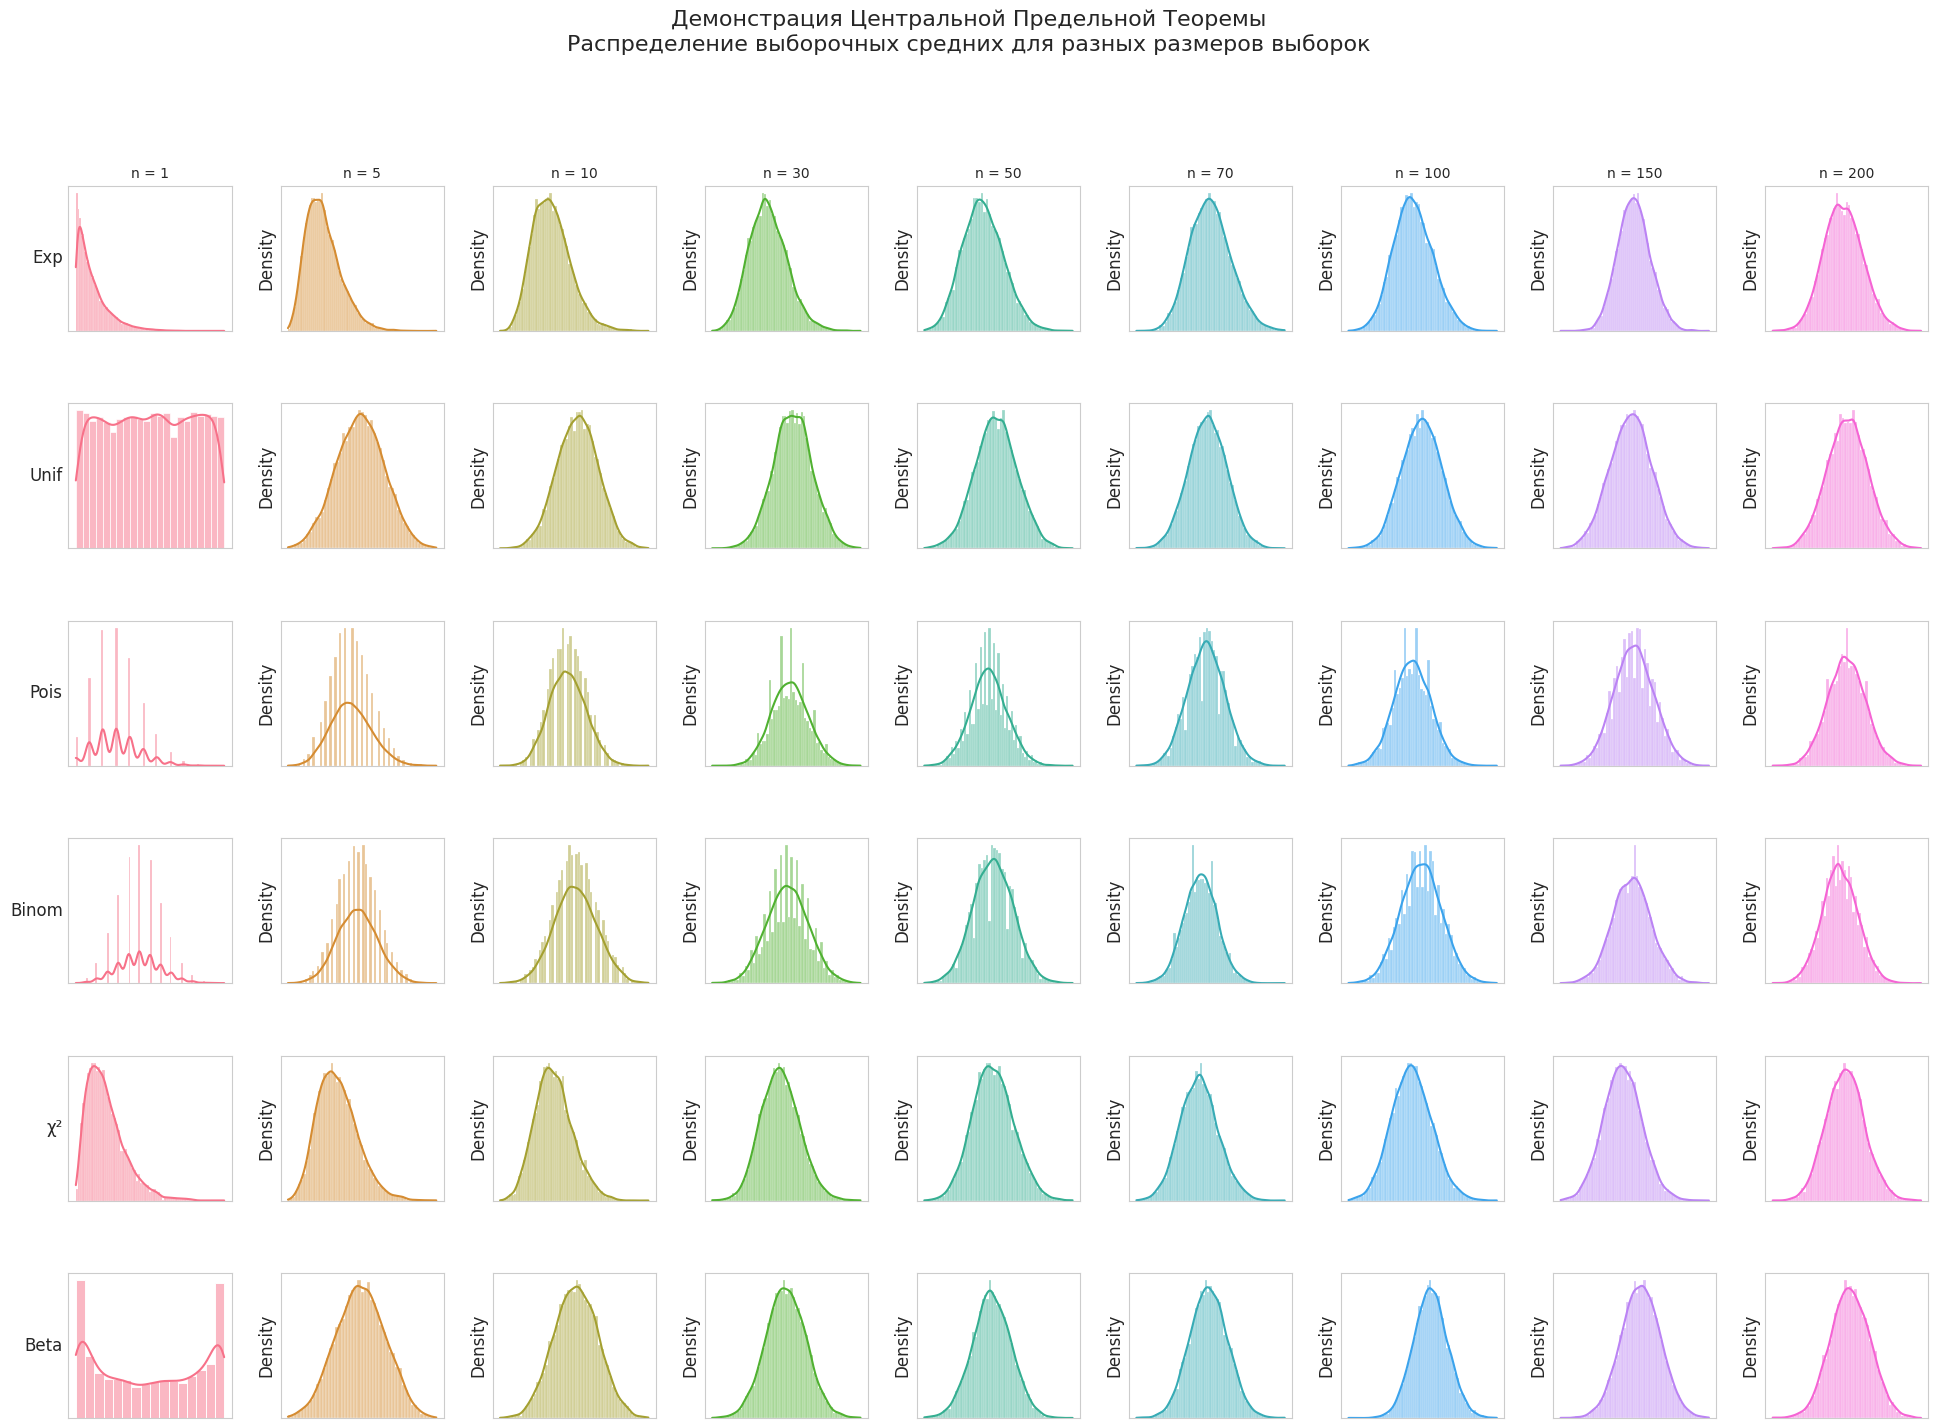

In [3]:
# Настройка стиля графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (24, 16)
plt.rcParams['font.size'] = 12
COLORS = sns.color_palette("husl", 9)

def generate_distribution(dist_type: str, params: Dict[str, float], size: int) -> np.ndarray:
    """Генерирует выборку из заданного распределения"""
    generators = {
        'exponential': lambda: np.random.exponential(params.get('scale', 1.0), size),
        'uniform': lambda: np.random.uniform(params.get('low', 0), params.get('high', 1), size),
        'poisson': lambda: np.random.poisson(params.get('lam', 5), size),
        'binomial': lambda: np.random.binomial(params.get('n', 10), params.get('p', 0.5), size),
        'chi2': lambda: np.random.chisquare(params.get('df', 2), size),
        'beta': lambda: np.random.beta(params.get('a', 2), params.get('b', 5), size),
    }
    return generators[dist_type]()

def calculate_theoretical_params(dist_type: str, params: Dict[str, float]) -> Tuple[float, float]:
    """Вычисляет теоретические среднее и стандартное отклонение"""
    if dist_type == 'exponential':
        mean = params.get('scale', 1.0)
        std = mean
    elif dist_type == 'uniform':
        low, high = params.get('low', 0), params.get('high', 1)
        mean, std = (low+high)/2, np.sqrt((high-low)**2/12)
    elif dist_type == 'poisson':
        mean = std = np.sqrt(params.get('lam', 5))
    elif dist_type == 'binomial':
        n, p = params.get('n', 10), params.get('p', 0.5)
        mean, std = n*p, np.sqrt(n*p*(1-p))
    elif dist_type == 'chi2':
        df = params.get('df', 2)
        mean, std = df, np.sqrt(2*df)
    elif dist_type == 'beta':
        a, b = params.get('a', 2), params.get('b', 5)
        mean = a/(a+b)
        std = np.sqrt(a*b/((a+b)**2*(a+b+1)))
    return mean, std

def plot_clt_grid():
    """Создает сетку 6x9 графиков для демонстрации ЦПТ"""
    distributions = [
        ('exponential', {'scale': 2.0}),
        ('uniform', {'low': 0, 'high': 10}),
        ('poisson', {'lam': 3}),
        ('binomial', {'n': 20, 'p': 0.3}),
        ('chi2', {'df': 5}),
        ('beta', {'a': 0.5, 'b': 0.5})
    ]
    sample_sizes = [1, 5, 10, 30, 50, 70, 100, 150, 200]
    num_samples = 10000

    fig, axes = plt.subplots(6, 9, figsize=(24, 16))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    for row, (dist_type, params) in enumerate(distributions):
        mean, std = calculate_theoretical_params(dist_type, params)

        for col, n in enumerate(sample_sizes):
            ax = axes[row, col]

            # Генерация выборочных средних
            sample_means = np.array([np.mean(generate_distribution(dist_type, params, n))
                                   for _ in range(num_samples)])

            # Построение гистограммы
            sns.histplot(sample_means, ax=ax, kde=True, color=COLORS[col], stat='density')

            # Настройка отображения
            if row == 0:
                ax.set_title(f"n = {n}", fontsize=10)
            if col == 0:
                dist_name = {
                    'exponential': 'Exp',
                    'uniform': 'Unif',
                    'poisson': 'Pois',
                    'binomial': 'Binom',
                    'chi2': 'χ²',
                    'beta': 'Beta'
                }[dist_type]
                ax.set_ylabel(dist_name, fontsize=12, rotation=0, ha='right', va='center')

            ax.set_xticks([])
            ax.set_yticks([])

    plt.suptitle("Демонстрация Центральной Предельной Теоремы\nРаспределение выборочных средних для разных размеров выборок",
                fontsize=16, y=0.99)
    plt.show()


plot_clt_grid()

#### Асимптотика и дельта-метод

Пусть у нас есть оценка $\hat{\theta}_n$ параметра $\theta$, и мы знаем её асимптотику:

$$
\sqrt{n}(\hat{\theta}_n - \theta) \xrightarrow{d} \mathcal{N}(0, \Sigma).
$$

Бывают случаи, когда нас интересует **не сама $\theta$**, а некоторая **функция** $g(\theta)$. Примеры:

* $g(\theta) = e^\theta$ — odds ratio в логистике.
* $g(\theta_1,\theta_2) = \theta_1/\theta_2$ — отношение двух параметров (ratio-метрика).
* $g(\mu_A,\mu_B) = \mu_B/\mu_A - 1$ — uplift для средней метрики.

Хочется получить **асимптотическое распределение** $g(\hat{\theta}_n)$, чтобы:

* посчитать дисперсию $\mathrm{Var}(g(\hat{\theta}_n))$;
* построить доверительный интервал для $g(\theta)$.

Одним из популярных вариантов решения является приблизить $g(\hat{\theta}_n)$ **линейной функцией** от $(\hat{\theta}_n - \theta)$ через разложение Тейлора.

**Одномерный дельта-метод**

Пусть $\theta\in\mathbb{R}$, $\hat{\theta}_n$ — оценка, такая что

$$
\sqrt{n}(\hat{\theta}_n - \theta) \xrightarrow{d} \mathcal{N}(0, \sigma^2).
$$

Пусть также $g:\mathbb{R}\to\mathbb{R}$ дифференцируема в точке $\theta$, и $g'(\theta)$ конечна.

Разложение Тейлора первого порядка вокруг точки $\theta$:

$$
g(\hat{\theta}_n)
= g(\theta) + g'(\theta)(\hat{\theta}_n - \theta) + R_n,
$$

где остаток $R_n$ по порядку квадратичен по $(\hat{\theta}_n - \theta)$.

Если $\sqrt{n}(\hat{\theta}_n - \theta) = O_p(1)^{(1)}$, то $\hat{\theta}_n - \theta = O_p(n^{-1/2}) \Rightarrow (\hat{\theta}_n - \theta)^2 = O_p(n^{-1})$. Следовательно $R_n = O_p(1/n)$.

Умножим разность на $\sqrt{n}$:

$$
\sqrt{n}\bigl(g(\hat{\theta}_n) - g(\theta)\bigr)
= g'(\theta)\sqrt{n}(\hat{\theta}_n - \theta) + \sqrt{n}R_n.
$$

Первый член имеет предел по распределению: $\sqrt{n}(\hat{\theta}_n - \theta) \to_d \mathcal{N}(0,\sigma^2)$, поэтому $g'(\theta)\sqrt{n}(\hat{\theta}_n - \theta) \to_d g'(\theta)Z$, где $Z\sim\mathcal{N}(0,\sigma^2)$.

Второй член $\sqrt{n}R_n = O_p(1/\sqrt{n}) \to_p 0$.

По [теореме Слуцкого](https://ru.wikipedia.org/wiki/Теорема_Слуцкого)

$$
\sqrt{n}\bigl(g(\hat{\theta}_n) - g(\theta)\bigr)
\xrightarrow{d} g'(\theta)Z \sim \mathcal{N}\bigl(0,\,[g'(\theta)]^2\sigma^2\bigr).
$$

Отсюда: при больших $n$

$$
g(\hat{\theta}_n) \approx \mathcal{N}\left(
g(\theta),\ \frac{[g'(\theta)]^2\sigma^2}{n}
\right).
$$

____

ㅤ(1) Говорят, что последовательность случайных величин ${X_n}$ **ограничена по вероятности** (bounded in probability), и записывают это как $X_n = O_p(1)$, если для любого $\epsilon > 0$существуют такие конечные константы $M_\epsilon$ и $N_\epsilon$, что для всех $n > N_\epsilon$ выполняется:

$$
P(|X_n| > M_\epsilon) < \epsilon
$$

Это означает, что последовательность $X_n$ **не "убегает" на бесконечность** с положительной вероятностью при росте $n$. Вероятность того, что $|X_n|$ превысит какой-то большой, но конечный порог $M$, можно сделать сколь угодно малой, выбрав достаточно большое $n$.

Условие $\sqrt{n}(\hat{\theta}_n - \theta) = O_p(1)$ говорит нам о **скорости сходимости** оценки $\hat{\theta}_n$ к истинному параметру $\theta$. Оно утверждает, что величина ошибки оценки, "усиленная" множителем $\sqrt{n}$, ведет себя стабильно (не взрывается). Это эквивалентно тому, что сама ошибка оценки $(\hat{\theta}_n - \theta)$ убывает со скоростью $n^{-1/2}$.

**Многомерный дельта-метод**

Пусть теперь $\theta\in\mathbb{R}^k$, оценка $\hat{\theta}_n\in\mathbb{R}^k$ и $\sqrt{n}(\hat{\theta}_n - \theta) \xrightarrow{d} \mathcal{N}(0,\Sigma)$.

Пусть $g:\mathbb{R}^k\to\mathbb{R}$ дифференцируема в окрестности $\theta$. Её градиент в точке $\theta$:

$$
\nabla g(\theta) =
\begin{pmatrix}
\frac{\partial g}{\partial \theta_1}(\theta) \\
\vdots \\
\frac{\partial g}{\partial \theta_k}(\theta)
\end{pmatrix}
$$

Разложение Тейлора первого порядка даёт следующее разложение
$$g(\hat{\theta}_n) = g(\theta) + \nabla g(\theta)^\top(\hat{\theta}_n - \theta) + R_n$$

где остаток $R_n$ по порядку $\|\hat{\theta}_n - \theta\|^2$.

При $\sqrt{n}(\hat{\theta}_n - \theta) = O_p(1)$ получаем $R_n = O_p(1/n)$ и, как раньше,

$$
\sqrt{n}\bigl(g(\hat{\theta}_n) - g(\theta)\bigr)
= \nabla g(\theta)^\top \sqrt{n}(\hat{\theta}_n - \theta) + \sqrt{n}R_n
$$


Пусть

$$
Z = \lim_{n\to\infty}^{d} \sqrt{n}(\hat{\theta}_n - \theta) \sim \mathcal{N}(0,\Sigma).
$$

Тогда по Слуцкому

$$
\sqrt{n}\bigl(g(\hat{\theta}_n) - g(\theta)\bigr)
\xrightarrow{d} \nabla g(\theta)^\top Z.
$$

Линейная комбинация нормального вектора снова нормальна.
$$
\mathrm{Var}(\nabla g(\theta)^\top Z) = \nabla g(\theta)^\top \Sigma \nabla g(\theta).
$$

Поэтому

$$
\sqrt{n}\bigl(g(\hat{\theta}_n) - g(\theta)\bigr)
\xrightarrow{d} \mathcal{N}\bigl(0,\ \nabla g(\theta)^\top \Sigma \nabla g(\theta)\bigr)
$$

и, следовательно,

$$
g(\hat{\theta}_n) \approx \mathcal{N}\left(
g(\theta),\ \frac{1}{n}\,\nabla g(\theta)^\top \Sigma \nabla g(\theta)
\right)
$$

**Когда дельта-метод может работать плохо:**

* Когда производная $g'(\theta)$ или градиент $\nabla g(\theta)$ очень малы, а вторые производные велики (функция сильно нелинейна).
* Когда знаменатели (например, $\mu_A$ или $r_A$) близки к нулю — формулы становятся численно нестабильными, дисперсии взлетают.
* При очень малых выборках, когда асимптотика (ЦПТ) ещё не «включилась».

Теперь применим дельта-метод к классической ratio-метрике. В одной группе для каждого юзера $i=1,\dots,n$ наблюдаем пару $(X_i, Y_i)$:

* $X_i$ — числитель (например, клики или выручка)
* $Y_i$ — знаменатель (например, показы, сессии, время и т.д.), причём $\mathbb{E}Y_i > 0$


**Параметры и оценка:**

Определим истинные средние $\mu_X = \mathbb{E}[X_i]$ и $\mu_Y = \mathbb{E}[Y_i]$. Нас интересует параметр $r = \frac{\mu_X}{\mu_Y}$, который описывает ratio-метрику **на уровне популяции**.

Его естественная оценка (ratio of means):

$$
\hat{\mu}_X = \frac{1}{n}\sum_{i=1}^n X_i,\quad
\hat{\mu}_Y = \frac{1}{n}\sum_{i=1}^n Y_i,
$$

$$
\hat{r} = \frac{\hat{\mu}_X}{\hat{\mu}_Y}.
$$

*Примечание: это **отношение средних**, а не среднее индивидуальных отношений $X_i/Y_i$, что является другой оценкой со своим поведением.*

**Асимптотическое распределение:**

Рассмотрим вектор на одного пользователя $Z_i = \begin{pmatrix} X_i \\ Y_i \end{pmatrix}$. Его характеристики:
- Вектор средних: $\mu = \begin{pmatrix} \mu_X \\ \mu_Y \end{pmatrix}$
- Ковариационная матрица: $\Sigma = \begin{pmatrix} \sigma_X^2 & \sigma_{XY} \\ \sigma_{XY} & \sigma_Y^2 \end{pmatrix}$

Согласно ЦПТ:

$$
\sqrt{n} \begin{pmatrix} \hat{\mu}_X - \mu_X \\ \hat{\mu}_Y - \mu_Y \end{pmatrix} \xrightarrow{d} \mathcal{N}\Biggl( \begin{pmatrix} 0 \\ 0 \end{pmatrix}, \Sigma \Biggr).
$$

То есть $(\hat{\mu}_X, \hat{\mu}_Y)$ асимптотически нормален с ковариацией $\Sigma/n$.

**Применение дельта-метода:**

Определим функцию $g(\mu_X,\mu_Y) = \frac{\mu_X}{\mu_Y}$. Градиент:

$$
\frac{\partial g}{\partial \mu_X} = \frac{1}{\mu_Y}, \quad
\frac{\partial g}{\partial \mu_Y} = -\frac{\mu_X}{\mu_Y^2}.
$$

В матричной форме:

$$
\nabla g(\mu_X,\mu_Y) = \begin{pmatrix} 1/\mu_Y \\[4pt] -\mu_X/\mu_Y^2 \end{pmatrix}.
$$

По многомерному дельта-методу асимптотическая дисперсия $\hat{r} = g(\hat{\mu}_X,\hat{\mu}_Y)$ равна:

$$
\mathrm{Var}(\hat{r}) \approx \frac{1}{n}\, \nabla g(\mu_X,\mu_Y)^\top \Sigma \nabla g(\mu_X,\mu_Y).
$$

**Раскрытие квадратичной формы:**

Пусть $a = \nabla g(\mu_X,\mu_Y) = \begin{pmatrix} a_1 \\ a_2 \end{pmatrix} = \begin{pmatrix} 1/\mu_Y \\ -\mu_X/\mu_Y^2 \end{pmatrix}$.

Тогда:

$$
a^\top \Sigma a = a_1^2 \sigma_X^2 + 2a_1 a_2 \sigma_{XY} + a_2^2 \sigma_Y^2.
$$

Подставляем компоненты:

- $a_1^2 \sigma_X^2 = \frac{1}{\mu_Y^2}\sigma_X^2$
- $2 a_1 a_2 \sigma_{XY} = 2 \cdot \frac{1}{\mu_Y} \cdot \left(-\frac{\mu_X}{\mu_Y^2}\right)\sigma_{XY} = -2\,\frac{\mu_X}{\mu_Y^3}\sigma_{XY}$
- $a_2^2 \sigma_Y^2 = \left(-\frac{\mu_X}{\mu_Y^2}\right)^2 \sigma_Y^2 = \frac{\mu_X^2}{\mu_Y^4}\sigma_Y^2$

**Итоговая формула дисперсии:**

$$
\mathrm{Var}(\hat{r}) \approx \frac{1}{n}\left[ \frac{\sigma_X^2}{\mu_Y^2} + \frac{\mu_X^2}{\mu_Y^4}\sigma_Y^2 - 2\frac{\mu_X}{\mu_Y^3}\sigma_{XY} \right].
$$

**Интерпретация компонентов:**
- Первое слагаемое — вклад вариации числителя
- Второе слагаемое — вклад вариации знаменателя  
- Третье слагаемое — поправка на корреляцию между $X$ и $Y$

**Практическая оценка:**

На практике параметры неизвестны, поэтому используем выборочные оценки:

$$
\hat{\mu}_X = \frac{1}{n}\sum X_i,\quad \hat{\mu}_Y = \frac{1}{n}\sum Y_i
$$

$$
\hat{\sigma}_X^2 = \frac{1}{n-1}\sum (X_i - \hat{\mu}_X)^2,\quad \hat{\sigma}_Y^2 = \frac{1}{n-1}\sum (Y_i - \hat{\mu}_Y)^2
$$

$$
\hat{\sigma}_{XY} = \frac{1}{n-1}\sum (X_i - \hat{\mu}_X)(Y_i - \hat{\mu}_Y)
$$

Окончательная формула для оценки дисперсии:

$$
\widehat{\mathrm{Var}}(\hat{r}) = \frac{1}{n}\left[ \frac{\hat{\sigma}_X^2}{\hat{\mu}_Y^2} + \frac{\hat{\mu}_X^2}{\hat{\mu}_Y^4}\,\hat{\sigma}_Y^2 - 2\,\frac{\hat{\mu}_X}{\hat{\mu}_Y^3}\,\hat{\sigma}_{XY} \right]$$

In [4]:
import numpy as np

def simulate_ratio_var(n=1000, reps=5000, seed=0):
    """
    Демонстрация для ratio-метрики в одной группе: r = mean(X) / mean(Y).

    Генерируем данные:
    - X ~ Poisson(0.4)
    - Y ~ Poisson(2.0) + 1  (чтобы Y > 0)

    Сравниваем:
    - эмпирическую дисперсию \hat r по повторениям
    - среднюю оценку дисперсии по дельта-методу
    """
    rng = np.random.default_rng(seed)
    rs = []
    delta_vars = []

    for _ in range(reps):
        X = rng.poisson(0.4, size=n)
        Y = rng.poisson(2.0, size=n) + 1

        mu_X_hat = X.mean()
        mu_Y_hat = Y.mean()
        r_hat = mu_X_hat / mu_Y_hat
        rs.append(r_hat)

        sigma_X2_hat = X.var(ddof=1)
        sigma_Y2_hat = Y.var(ddof=1)
        sigma_XY_hat = np.cov(X, Y, ddof=1)[0, 1]

        delta_var = (
            sigma_X2_hat / mu_Y_hat**2
            + (mu_X_hat**2) * sigma_Y2_hat / mu_Y_hat**4
            - 2 * mu_X_hat * sigma_XY_hat / mu_Y_hat**3
        ) / n
        delta_vars.append(delta_var)

    return np.array(rs), np.array(delta_vars)

rs, delta_vars = simulate_ratio_var()
emp_var = rs.var(ddof=1)
delta_var = delta_vars.mean()

print("Эмпирическая дисперсия  Var(r_hat):", emp_var)
print("Средняя дельта-оценка  Var(r_hat):", delta_var)
print("Относительная ошибка:", (delta_var / emp_var) - 1)

Эмпирическая дисперсия  Var(r_hat): 4.965781865354104e-05
Средняя дельта-оценка  Var(r_hat): 4.845373182241069e-05
Относительная ошибка: -0.02424767868945621


#### Типы метрик в A/B-тестах: что считаем и на каком уровне

Перед тем как строить доверительные интервалы, важно зафиксировать:

1. **Единицу анализа** (обычно пользователь).
2. **Уровень агрегации** (event $\rightarrow$ user $\rightarrow$ group).
3. **Тип метрики** (value / ratio / персентиль).
4. **Тип эффекта**, который сравниваем:
   - absolute effect: $e = \theta_t - \theta_c$;
   - uplift (relative effect): $u = \dfrac{\theta_t}{\theta_c} - 1$.

Ниже — краткий справочник по типам метрик.

**Value-метрики**

**Определение.** Есть поюзерная величина $X_i$ (например, трата пользователя за период). Тогда value-метрика — это среднее:

$$
\mu_g = \mathbb{E}[X_i \mid g(i)=g], \qquad
\hat{\mu}_g = \frac{1}{n_g}\sum_{i: g(i)=g} X_i.
$$

**Примеры.**
- средний чек / GMV на пользователя;
- среднее число заказов на пользователя;
- средняя длительность сессии;
- конверсия на user-уровне (0/1 на пользователя) — тоже value-метрика, потому что это среднее Бернулли.

**Особенности.**
- простая статистика и интерпретация;
- чувствительна к тяжёлым хвостам и выбросам.

**Ratio-метрики**

**Определение.** Берём числитель и знаменатель и нормируем:

$$
R_g = \frac{\mathbb{E}[X_i]}{\mathbb{E}[Y_i]}, \qquad
\hat{R}_g = \frac{\bar{X}_g}{\bar{Y}_g}.
$$

**Примеры.**
- CTR = клики / показы;
- AR = принятые офферы / показанные офферы;
- CR = завершённые / принятые;
- Trips per hour = поездки / часы онлайна.

**Особенности.**
- нелинейность: $\hat{R}_g$ — функция двух случайных величин;
- важно корректно выбрать уровень агрегации (часто нужно агрегировать на пользователя);
- для ДИ обычно применяют **дельта-метод** или **линеаризацию**.

**Персентильные (квантильные) метрики**

**Определение.** Для value-величины $X$ квантиль уровня $p$:

$$
x_p = F^{-1}(p).
$$

**Примеры.**
- $p95$ времени доставки;
- $p90$ latency;
- $p99$ времени ответа сервиса.

**Особенности.**
- полезны для контроля хвостов (SLA/SLO);
- доверительные интервалы строятся через ранги (порядковые статистики);
- при **кластеризации по пользователям** нужна корректировка дисперсии, и здесь дельта-метод появляется как часть конструкции.

#### Доверительные интервалы через дельта-метод

Почти все формулы ниже устроены одинаково. Каждый раз мы делаем одно и то же:

1. Выбираем **оценку метрики** как функцию от “простых” средних/сумм.  
   Например, ratio-метрика — это функция $g(\mu_X,\mu_Y)=\mu_X/\mu_Y$.

2. Понимаем, что вектор оценок средних (например, $(\bar X,\bar Y)$) по ЦПТ **асимптотически нормален**:
   $$
   \sqrt{n}\bigl(\hat{\theta}-\theta\bigr)\Rightarrow \mathcal{N}(0,\Sigma).
   $$

3. Линеаризуем метрику $g$ около истинной точки: это “первый член Тейлора”
   $$
   g(\hat{\theta}) \approx g(\theta) + \nabla g(\theta)^\top(\hat{\theta}-\theta).
   $$
   Смысл: около правды функция ведёт себя почти линейно, а значит мы можем “протащить” нормальность через $g$.

4. Получаем дисперсию/SE как “проекцию ковариации на градиент”:
   $$
   \mathrm{Var}\bigl(g(\hat{\theta})\bigr)\approx \frac{1}{n}\,\nabla g(\theta)^\top \Sigma \,\nabla g(\theta),
   \qquad
   \mathrm{SE}=\sqrt{\mathrm{Var}}.
   $$

5. Подставляем оценки вместо неизвестных параметров (plug-in) и строим ДИ:
   $$
   \widehat{g}\ \pm\ z_{1-\alpha/2}\,\widehat{\mathrm{SE}}.
   $$

Дальше всё отличие между метриками — **в том, что именно считать за $\theta$, какая функция $g$**, и как оценить $\Sigma$ (дисперсия/ковариация).

##### User-level метрики

**Модель для user-метрики**

Пусть:

* В группе A наблюдаем $Z_1^A,\dots,Z_{n_A}^A$ — user-метрика (например, выручка на пользователя за период, конверсия и т.п.).
* В группе B — $Z_1^B,\dots,Z_{n_B}^B$.

Определим истинные средние и дисперсии:

$$
\mu_A = \mathbb{E}[Z_i^A],\quad \mu_B = \mathbb{E}[Z_i^B],
$$

$$
\sigma_A^2 = \mathrm{Var}(Z_i^A),\quad \sigma_B^2 = \mathrm{Var}(Z_i^B).
$$

Выборочные средние:

$$
\hat{\mu}_A = \frac{1}{n_A}\sum_{i=1}^{n_A} Z_i^A,\quad
\hat{\mu}_B = \frac{1}{n_B}\sum_{i=1}^{n_B} Z_i^B.
$$

ЦПТ по группам даёт:

$$
\sqrt{n_A}(\hat{\mu}_A - \mu_A) \xrightarrow{d} \mathcal{N}(0,\sigma_A^2),\quad
\sqrt{n_B}(\hat{\mu}_B - \mu_B) \xrightarrow{d} \mathcal{N}(0,\sigma_B^2).
$$

Если группы набирались независимо, то $\hat{\mu}_A$ и $\hat{\mu}_B$ асимптотически независимы.

###### **Absolute effect**

Самый простой эффект — **разность средних**:

$$
\Delta_{\text{abs}}^{\text{user}} = \mu_B - \mu_A.
$$

Поскольку это линейная комбинация двух асимптотически нормальных и независимых оценок, дисперсия просто складывается:

$$
\mathrm{Var}(\hat{\Delta}_{\text{abs}}^{\text{user}})
= \frac{\sigma_A^2}{n_A} + \frac{\sigma_B^2}{n_B}.
$$

На практике заменяем $\sigma_A^2, \sigma_B^2$ на выборочные дисперсии:

$$
\hat{\sigma}_A^2 = \frac{1}{n_A-1}\sum (Z_i^A - \hat{\mu}_A)^2,\quad
\hat{\sigma}_B^2 = \frac{1}{n_B-1}\sum (Z_i^B - \hat{\mu}_B)^2,
$$

$$
\widehat{\mathrm{Var}}(\hat{\Delta}_{\text{abs}}^{\text{user}})
= \frac{\hat{\sigma}_A^2}{n_A} + \frac{\hat{\sigma}_B^2}{n_B}.
$$

Стандартная ошибка:

$$
\widehat{\mathrm{SE}}(\hat{\Delta}_{\text{abs}}^{\text{user}})
= \sqrt{\frac{\hat{\sigma}_A^2}{n_A} + \frac{\hat{\sigma}_B^2}{n_B}}.
$$

Доверительный интервал:

$$
\hat{\Delta}_{\text{abs}}^{\text{user}} \pm
z_{1-\alpha/2}\, \widehat{\mathrm{SE}}(\hat{\Delta}_{\text{abs}}^{\text{user}}).
$$

Здесь дельта-метод формально не нужен — это простая линейная комбинация, и ЦПТ уже даёт всё, что надо.

###### **Uplift effect**

Relative-эффект (uplift) определим как

$$
\Delta_{\text{rel}}^{\text{user}} = \frac{\mu_B - \mu_A}{\mu_A} = \frac{\mu_B}{\mu_A} - 1.
$$

Это уже **нелинейная функция** от двух случайных величин $\hat{\mu}_A,\hat{\mu}_B$. Здесь применяется дельта-метод.

Возьмём вектор параметров

$$
\theta =
\begin{pmatrix} \mu_A \\ \mu_B \end{pmatrix}, \quad
\hat{\theta} =
\begin{pmatrix} \hat{\mu}_A \\ \hat{\mu}_B \end{pmatrix}.
$$

Асимптотически

$$
\hat{\theta} \approx \mathcal{N}\left(
\begin{pmatrix} \mu_A \\ \mu_B \end{pmatrix},
\
\begin{pmatrix}
\sigma_A^2/n_A & 0 \\
0 & \sigma_B^2/n_B
\end{pmatrix}
\right).
$$

Функция, задающая uplift (без минус единицы):

$$
\tilde{g}(\mu_A,\mu_B) = \frac{\mu_B}{\mu_A}.
$$

Разность с единицей не влияет на дисперсию, т.к. $\mathrm{Var}(X + \text{const}) = \mathrm{Var}(X)$.

Градиент:

$$
\frac{\partial \tilde{g}}{\partial \mu_A} = -\frac{\mu_B}{\mu_A^2},\quad
\frac{\partial \tilde{g}}{\partial \mu_B} = \frac{1}{\mu_A},
$$

$$
\nabla \tilde{g}(\mu_A,\mu_B) =
\begin{pmatrix}
-\frac{\mu_B}{\mu_A^2}\\[4pt]
\frac{1}{\mu_A}
\end{pmatrix}.
$$

Ковариационная матрица $\hat{\theta}$:

$$
\Sigma_\theta =
\begin{pmatrix}
\sigma_A^2/n_A & 0 \\
0 & \sigma_B^2/n_B
\end{pmatrix}.
$$

По дельта-методу

$$
\mathrm{Var}\bigl(\tilde{g}(\hat{\theta})\bigr)
\approx \nabla \tilde{g}^\top \Sigma_\theta \nabla \tilde{g}.
$$

Из-за диагональной структуры $\Sigma_\theta$:

$$
\mathrm{Var}\bigl(\tilde{g}(\hat{\theta})\bigr)
\approx \left(-\frac{\mu_B}{\mu_A^2}\right)^2 \frac{\sigma_A^2}{n_A}
+ \left(\frac{1}{\mu_A}\right)^2 \frac{\sigma_B^2}{n_B}.
$$

То есть для uplift-эффекта

$$
\mathrm{Var}\bigl(\hat{\Delta}_{\text{rel}}^{\text{user}}\bigr)
\approx
\frac{\mu_B^2}{\mu_A^4}\frac{\sigma_A^2}{n_A}
+ \frac{1}{\mu_A^2}\frac{\sigma_B^2}{n_B}.
$$

Стандартная ошибка и доверительный интервал считаются по той же схеме, что и раньше.

##### Ratio-метрики

**Модель в каждой группе**

Для группы $g \in \{A,B\}$ для каждого юзера $i=1,\dots,n_g$ наблюдаем пару $(X_i^{(g)}, Y_i^{(g)})$:

* $X_i^{(g)}$ — числитель (клики, покупки, выручка и т.д.);
* $Y_i^{(g)}$ — знаменатель (показы, сессии, время и т.д.).

Определим параметры:

$$
\mu_X^{(g)} = \mathbb{E}[X_i^{(g)}],\quad
\mu_Y^{(g)} = \mathbb{E}[Y_i^{(g)}] > 0,
$$

$$
\sigma_{X,g}^2 = \mathrm{Var}(X_i^{(g)}),\quad
\sigma_{Y,g}^2 = \mathrm{Var}(Y_i^{(g)}),\quad
\sigma_{XY,g} = \mathrm{Cov}(X_i^{(g)}, Y_i^{(g)}).
$$

Ratio-параметр в группе $g$:

$$
r_g = \frac{\mu_X^{(g)}}{\mu_Y^{(g)}}.
$$

Оценки:

$$
\hat{\mu}_X^{(g)} = \frac{1}{n_g}\sum_{i=1}^{n_g} X_i^{(g)},\quad
\hat{\mu}_Y^{(g)} = \frac{1}{n_g}\sum_{i=1}^{n_g} Y_i^{(g)},
$$

$$
\hat{r}_g = \frac{\hat{\mu}_X^{(g)}}{\hat{\mu}_Y^{(g)}}.
$$

Как мы уже выводили, для каждой группы $g$ по дельта-методу

$$
\mathrm{Var}(\hat{r}_g) \approx
\frac{1}{n_g}\left[
\frac{\sigma_{X,g}^2}{(\mu_Y^{(g)})^2}
+ \frac{(\mu_X^{(g)})^2}{(\mu_Y^{(g)})^4}\sigma_{Y,g}^2
- 2\,\frac{\mu_X^{(g)}}{(\mu_Y^{(g)})^3}\sigma_{XY,g}
\right].
$$

На практике заменяем на выборочные оценки $\hat{\mu}_X^{(g)},\hat{\mu}_Y^{(g)},\hat{\sigma}_{X,g}^2,\hat{\sigma}_{Y,g}^2,\hat{\sigma}_{XY,g}$.

###### Absolute effect

Absolute-эффект:

$$
\Delta_{\text{abs}}^{\text{ratio}} = r_B - r_A.
$$

Поскольку $\hat{r}_A$ и $\hat{r}_B$ основаны на независимых выборках, они асимптотически независимы. Тогда

$$
\mathrm{Var}\bigl(\hat{\Delta}_{\text{abs}}^{\text{ratio}}\bigr)
= \mathrm{Var}(\hat{r}_A) + \mathrm{Var}(\hat{r}_B).
$$

На практике

$$
\widehat{\mathrm{Var}}\bigl(\hat{\Delta}_{\text{abs}}^{\text{ratio}}\bigr)
= \widehat{\mathrm{Var}}(\hat{r}_A) + \widehat{\mathrm{Var}}(\hat{r}_B),
$$

где $\widehat{\mathrm{Var}}(\hat{r}_A),\widehat{\mathrm{Var}}(\hat{r}_B)$ получены по формуле из предыдущего пункта для каждой группы.

Доверительный интервал:

$$
\hat{\Delta}_{\text{abs}}^{\text{ratio}} \pm
z_{1-\alpha/2}\,\sqrt{
\widehat{\mathrm{Var}}(\hat{r}_A) + \widehat{\mathrm{Var}}(\hat{r}_B)
}.
$$

Здесь дельта-метод используется на уровне оценки каждой ratio-метрики, а разность — уже линейная комбинация.

###### Uplift effect

Relative-эффект для ratio-метрики обычно задают как

$$
\Delta_{\text{rel}}^{\text{ratio}} = \frac{r_B}{r_A} - 1.
$$

Это уже функция от **двух** случайных величин $(\hat{r}_A,\hat{r}_B)$. Снова применяем многомерный дельта-метод.


Из предыдущего шага:

* $\hat{r}_A \approx \mathcal{N}(r_A, \mathrm{Var}(\hat{r}_A))$,
* $\hat{r}_B \approx \mathcal{N}(r_B, \mathrm{Var}(\hat{r}_B))$.

Группы независимы ⇒ асимптотически

$$
\begin{pmatrix}\hat{r}_A\\\hat{r}_B\end{pmatrix}
\sim \mathcal{N}\left(
\begin{pmatrix} r_A \\ r_B \end{pmatrix},
\
\begin{pmatrix}
\mathrm{Var}(\hat{r}_A) & 0 \\
0 & \mathrm{Var}(\hat{r}_B)
\end{pmatrix}
\right).
$$


Функция uplift (без вычитания единицы):

$$
h(r_A,r_B) = \frac{r_B}{r_A}.
$$

Градиент:

$$
\frac{\partial h}{\partial r_A} = -\frac{r_B}{r_A^2},\quad
\frac{\partial h}{\partial r_B} = \frac{1}{r_A},
$$

$$
\nabla h(r_A,r_B) =
\begin{pmatrix}
-\frac{r_B}{r_A^2}\\[4pt]
\frac{1}{r_A}
\end{pmatrix}.
$$

Ковариационная матрица для $(\hat{r}_A,\hat{r}_B)$:

$$
\Sigma_r =
\begin{pmatrix}
\mathrm{Var}(\hat{r}_A) & 0 \\
0 & \mathrm{Var}(\hat{r}_B)
\end{pmatrix}.
$$

По дельта-методу

$$
\mathrm{Var}\bigl(h(\hat{r}_A,\hat{r}_B)\bigr)
\approx \nabla h^\top \Sigma_r \nabla h.
$$

Из-за диагональности $\Sigma_r$:

$$
\mathrm{Var}\bigl(h(\hat{r}_A,\hat{r}_B)\bigr)
\approx
\left(-\frac{r_B}{r_A^2}\right)^2 \mathrm{Var}(\hat{r}_A)
+ \left(\frac{1}{r_A}\right)^2 \mathrm{Var}(\hat{r}_B).
$$

Так как вычитание 1 не меняет дисперсию, то

$$
\mathrm{Var}\bigl(\Delta_{\text{rel}}^{\text{ratio}}\bigr)
= \mathrm{Var}\bigl(h(\hat{r}_A,\hat{r}_B) - 1\bigr)
= \mathrm{Var}\bigl(h(\hat{r}_A,\hat{r}_B)\bigr).
$$

На практике заменяем $r_A,r_B$ на $\hat{r}_A,\hat{r}_B$ и дисперсии на их оценки:

$$
\widehat{\mathrm{Var}}\bigl(\hat{\Delta}_{\text{rel}}^{\text{ratio}}\bigr)
= \frac{\hat{r}_B^2}{\hat{r}_A^4}\,\widehat{\mathrm{Var}}(\hat{r}_A)
+ \frac{1}{\hat{r}_A^2}\,\widehat{\mathrm{Var}}(\hat{r}_B).
$$

Стандартная ошибка и доверительный интервал:

$$
\widehat{\mathrm{SE}}\bigl(\hat{\Delta}_{\text{rel}}^{\text{ratio}}\bigr)
= \sqrt{\widehat{\mathrm{Var}}\bigl(\hat{\Delta}_{\text{rel}}^{\text{ratio}}\bigr)},
$$

$$
\hat{\Delta}_{\text{rel}}^{\text{ratio}}
\pm
z_{1-\alpha/2}\,
\widehat{\mathrm{SE}}\bigl(\hat{\Delta}_{\text{rel}}^{\text{ratio}}\bigr).
$$

##### Перцентильные метрики

Перцентили стоят особняком: на практике часто используют **ранговые доверительные интервалы**.

Ниже — два сценария:
1. данные независимы (например, поюзерная агрегация);
2. данные кластеризованы по пользователю (event-level с зависимостью внутри пользователя).

###### Персентильный ДИ на независимых данных (поюзерная агрегация)

Предположим, что у нас есть $n$ независимых наблюдений $X_1, \dots, X_n$, и мы хотим оценить квантиль уровня $p$.
Пусть истинный квантиль $x_p$ удовлетворяет

$$
\mathbb{P}(X_i \le x_p) = p.
$$

Введём индикатор $X_i^p = I\{X_i \le x_p\}$

Тогда $\overline{X}^p = \frac{1}{n} \sum_{i=1}^n X_i^p$ имеет примерно следующее распределение при больших $n$.

$$
\overline{X}^p \approx \mathcal{N}\!\left(p,\ \frac{p(1-p)}{n}\right)
$$

Строим нормальный ДИ для $p$ на уровне $(1 - \alpha)$:

$$
p \pm z_{1 - \alpha/2} \sqrt{\frac{p(1-p)}{n}}.
$$

Тогда граничные значения по доле — это

$$
p_L = p - z_{1 - \alpha/2} \sigma, \qquad
p_U = p + z_{1 - \alpha/2} \sigma.
$$

Умножая на $n$, получаем **интервал по рангу**:

$$
L = n p_L = n \left(p - z_{1 - \alpha/2} \sigma\right), \\
U = n p_U = n \left(p + z_{1 - \alpha/2} \sigma\right) + 1.
$$

Здесь $L$ и $U$ — индексы порядковых статистик в отсортированной выборке $X_{(1)} \le \dots \le X_{(n)}$.

Персентильный доверительный интервал строится тогда по принципу

1. Сортируем выборку $X_1, \dots, X_n$ по возрастанию и получаем порядковые статистики $X_{(1)}, \dots, X_{(n)}$.
2. Вычисляем $L$ и $U$ как выше (округляя до целых по какому‑то правилу).
3. **Персентильный ДИ для квантиля $x_p$**:

$$
\left[X_{(L)},\ X_{(U)}\right].
$$

###### Персентильный ДИ на зависимых данных (кластеризация по пользователю)

Во многих задачах данные приходят на уровне событий (поездки, клики), но важна кластеризация по пользователям:

- один пользователь может иметь много событий;
- события внутри пользователя зависимы;
- простое предположение "все события независимы" занижает дисперсию и приводит к слишком узким ДИ.

Подход:

1. Вводим индикатор для события $k$ (поездка, заказ)

   $$
   X_k^p = I\{X_k \le x_p\}.
   $$

2. Для каждого пользователя $i$ считаем
   - число событий: $N_i$;
   - число "успешных" событий: $S_i = \sum_{k \in i} X_k^p$.

3. Доля событий ниже квантиля оценивается как ratio‑метрика

   $$
   \hat{p} = \frac{\sum_i S_i}{\sum_i N_i}.
   $$

   При этом пара $(S_i, N_i)$ — поюзерная, и мы можем учесть кластеризацию.

4. Применяем дельта‑метод для ratio

   $$
   \hat{p} = \frac{\overline{S}}{\overline{N}},
   $$

   где

   $$
   \overline{S} = \frac{1}{n} \sum_{i=1}^n S_i, \qquad
   \overline{N} = \frac{1}{n} \sum_{i=1}^n N_i.
   $$

   Вычисляем выборочные дисперсии и ковариации по пользователям:
   $s_S^2$, $s_N^2$, $s_{SN}$ и используем формулу дельта‑метода, чтобы получить
   оценку дисперсии $\widehat{\mathrm{Var}}(\hat{p})$.

5. Получаем эффективное стандартное отклонение

   $$
   \hat{\sigma}_{\mathrm{eff}} = \sqrt{\widehat{\mathrm{Var}}(\hat{p})}.
   $$

6. Дальше делаем те же шаги, что и для независимого случая:

   $$
   p_L = p - z_{1 - \alpha/2} \hat{\sigma}_{\mathrm{eff}}, \qquad
   p_U = p + z_{1 - \alpha/2} \hat{\sigma}_{\mathrm{eff}},
   $$

   и дальше переводим их в ранги $L$ и $U$, после чего строим ДИ по порядковым статистикам.

Итог: мы получили **персентильный ДИ, корректный с учётом кластеризации по пользователю**.

#### Пример реализации

Ниже сопровождающий код: функции для построения доверительных интервалов под каждый тип метрик.

Мы сделаем три блока:

1. **Value-метрики**: разность средних (absolute) и uplift (relative) через дельта-метод (+ бутстрап как проверка).
2. **Ratio-метрики**: абсолютный эффект и uplift через дельта-метод, а также (опционально) линеаризация.
3. **Перцентили**: персентильный ДИ (iid) и вариант с поправкой на кластеризацию по пользователю, а также бутстрап для эффекта.

Во всех функциях:

- вход — массивы по пользователям (или таблица событий для перцентилей с кластеризацией);
- выход — точечная оценка и доверительный интервал уровня $(1-\alpha)$.

In [ ]:
import math
import numpy as np
import pandas as pd
from statistics import NormalDist

# -----------------------------
# База: z-критическое значение
# -----------------------------
def z_crit(alpha: float = 0.05) -> float:
    'Квантиль стандартной нормали z_{1-alpha/2}.'
    return NormalDist().inv_cdf(1 - alpha/2)

def _as_float_array(x) -> np.ndarray:
    return np.asarray(x, dtype=float)

# -----------------------------
# Универсальный бутстрап (iid по пользователям)
# -----------------------------
def bootstrap_ci_2sample_users(
    x_c, x_t,
    stat_fn,
    B: int = 2000,
    alpha: float = 0.05,
    seed: int = 0
):
    '''
    Перценильный бутстрап-ДИ для двух выборок (контроль/тест).

    stat_fn(sample_c, sample_t) -> float, возвращает эффект.
    Важно: этот бутстрап корректен для iid-наблюдений на user-уровне.
    Для кластеризации (event-метрики) нужен кластерный бутстрап по пользователям.
    '''
    rng = np.random.default_rng(seed)
    x_c = _as_float_array(x_c); x_t = _as_float_array(x_t)
    n_c, n_t = len(x_c), len(x_t)

    eff_hat = float(stat_fn(x_c, x_t))
    effs = np.empty(B, dtype=float)
    for b in range(B):
        bc = x_c[rng.integers(0, n_c, size=n_c)]
        bt = x_t[rng.integers(0, n_t, size=n_t)]
        effs[b] = float(stat_fn(bc, bt))

    lo = float(np.quantile(effs, alpha/2))
    hi = float(np.quantile(effs, 1 - alpha/2))
    return eff_hat, (lo, hi)

# =========================================================
# 1) VALUE-МЕТРИКИ: mean / abs и mean / uplift (delta)
# =========================================================
def ci_mean_abs(x_c, x_t, alpha: float = 0.05):
    '''
    Absolute effect для value-метрики: e = mu_t - mu_c.

    Что происходит:
    - по ЦПТ выборочное среднее примерно нормально;
    - дисперсия среднего оценивается как s^2/n;
    - для разности средних дисперсии складываются (группы независимы).
    '''
    x_c = _as_float_array(x_c); x_t = _as_float_array(x_t)
    n_c, n_t = len(x_c), len(x_t)

    mu_c = float(x_c.mean()); mu_t = float(x_t.mean())
    delta = mu_t - mu_c

    s2_c = float(x_c.var(ddof=1)); s2_t = float(x_t.var(ddof=1))
    var = s2_c / n_c + s2_t / n_t
    se = math.sqrt(var)

    z = z_crit(alpha)
    return delta, (delta - z*se, delta + z*se), se

def ci_mean_uplift_delta(x_c, x_t, alpha: float = 0.05):
    '''
    Uplift для value-метрики: u = mu_t/mu_c - 1.

    Почему это работает:
    - (mu_t_hat, mu_c_hat) примерно нормальны;
    - uplift = нелинейная функция от двух средних;
    - дельта-метод линеаризует эту функцию и "прокидывает" дисперсии.
    '''
    x_c = _as_float_array(x_c); x_t = _as_float_array(x_t)
    n_c, n_t = len(x_c), len(x_t)

    mu_c = float(x_c.mean()); mu_t = float(x_t.mean())
    u = mu_t / mu_c - 1.0

    s2_c = float(x_c.var(ddof=1)); s2_t = float(x_t.var(ddof=1))

    # Производные g(mu_t, mu_c)=mu_t/mu_c-1:
    # dg/dmu_t = 1/mu_c
    # dg/dmu_c = -mu_t/mu_c^2
    var = (s2_t / n_t) * (1.0 / (mu_c**2)) + (s2_c / n_c) * ((mu_t**2) / (mu_c**4))
    se = math.sqrt(var)

    z = z_crit(alpha)
    return u, (u - z*se, u + z*se), se

# -----------------------------
# Пример: value-метрика (heavy tail)
# -----------------------------
rng = np.random.default_rng(42)
n = 4000

# трата пользователя: гамма-подобный heavy tail
x_c = rng.gamma(shape=2.0, scale=50.0, size=n)
x_t = rng.gamma(shape=2.0, scale=52.0, size=n)

abs_est, abs_ci, abs_se = ci_mean_abs(x_c, x_t)
upl_est, upl_ci, upl_se = ci_mean_uplift_delta(x_c, x_t)

print('VALUE / absolute')
print('  est:', abs_est, 'CI:', abs_ci, 'SE:', abs_se)

print('\nVALUE / uplift (delta method)')
print('  est:', upl_est, 'CI:', upl_ci, 'SE:', upl_se)

# Бутстрап uplift как sanity-check (не обязателен, но полезен при тяжёлых хвостах)
def uplift_stat(bc, bt):
    return bt.mean() / bc.mean() - 1.0

upl_b_hat, upl_b_ci = bootstrap_ci_2sample_users(x_c, x_t, uplift_stat, B=2000, alpha=0.05, seed=1)
print('\nVALUE / uplift (bootstrap, percentile)')
print('  est:', upl_b_hat, 'CI:', upl_b_ci)

VALUE / absolute
  est: 2.8737381183674415 CI: (-0.2942583024375338, 6.041734539172417) SE: 1.6163544053838375

VALUE / uplift (delta method)
  est: 0.02860561160094033 CI: (-0.00335776270328126, 0.060568985905161916) SE: 0.016308143698733558

VALUE / uplift (bootstrap, percentile)
  est: 0.02860561160094033 CI: (-0.0038311564308752847, 0.06272839623411358)


In [ ]:
import math
import numpy as np

# =========================================================
# 2) RATIO-МЕТРИКИ: abs и uplift (delta), + линеаризация
# =========================================================

def ratio_sum(x, y) -> float:
    'Оценка ratio: r_hat = sum(x)/sum(y) (эквивалентно mean(x)/mean(y)).'
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    return float(x.sum() / y.sum())

def var_ratio_delta(x, y) -> float:
    '''
    Дельта-оценка Var(r_hat) для r_hat = mean(X)/mean(Y).

    На user-уровне считаем:
    - выборочные Var(X), Var(Y), Cov(X,Y);
    - подставляем их в формулу дельта-метода.
    '''
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    n = len(x)
    mx = float(x.mean()); my = float(y.mean())

    vx = float(x.var(ddof=1))
    vy = float(y.var(ddof=1))
    cxy = float(np.cov(x, y, ddof=1)[0, 1])

    var = (vx / (my**2) + (mx**2) * vy / (my**4) - 2 * mx * cxy / (my**3)) / n
    return float(var)

def ci_ratio_abs_delta(x_c, y_c, x_t, y_t, alpha: float = 0.05):
    '''
    Absolute effect для ratio-метрики: e = r_t - r_c.
    Важный момент: внутри группы Var(r_hat) считаем по дельта-методу, затем складываем.
    '''
    r_c = ratio_sum(x_c, y_c)
    r_t = ratio_sum(x_t, y_t)
    delta = r_t - r_c

    var = var_ratio_delta(x_c, y_c) + var_ratio_delta(x_t, y_t)
    se = math.sqrt(var)

    z = z_crit(alpha)
    return delta, (delta - z*se, delta + z*se), se

def ci_ratio_uplift_delta(x_c, y_c, x_t, y_t, alpha: float = 0.05):
    '''
    Uplift для ratio-метрики: u = r_t/r_c - 1.

    Что происходит:
    - сначала для каждой группы оцениваем r_hat и Var(r_hat) по дельта-методу;
    - затем ещё раз применяем дельта-метод к функции g(r_t, r_c)=r_t/r_c-1.
    '''
    r_c = ratio_sum(x_c, y_c)
    r_t = ratio_sum(x_t, y_t)
    u = r_t / r_c - 1.0

    var_rt = var_ratio_delta(x_t, y_t)
    var_rc = var_ratio_delta(x_c, y_c)

    # dg/dr_t = 1/r_c, dg/dr_c = -r_t/r_c^2
    var = (1.0 / (r_c**2)) * var_rt + ((r_t**2) / (r_c**4)) * var_rc
    se = math.sqrt(var)

    z = z_crit(alpha)
    return u, (u - z*se, u + z*se), se

def linearize_ratio_type1(x, y, r_base: float):
    '''
    Линеаризация типа 1: L_i = x_i - r_base * y_i.
    Если r_base берём из контроля (r_c), то сравнение средних L_i превращает ratio сравнение в value задачу.
    '''
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    return x - r_base * y

def ci_ratio_abs_linearized(x_c, y_c, x_t, y_t, alpha: float = 0.05):
    '''
    ДИ для эффекта ratio через линеаризацию (приближённо) и стандартный ДИ для средних.

    Логика:
    - берём r_base = r_c,
    - считаем L_i в каждой группе,
    - сравниваем mean(L) между группами как value-метрику,
    - переводим эффект обратно в "единицы ratio" делением на средний знаменатель теста (приближённо).
    '''
    r_base = ratio_sum(x_c, y_c)

    L_c = linearize_ratio_type1(x_c, y_c, r_base)
    L_t = linearize_ratio_type1(x_t, y_t, r_base)

    # value CI для mean(L_t)-mean(L_c)
    dL, (loL, hiL), seL = ci_mean_abs(L_c, L_t, alpha=alpha)

    # перевод в ratio-единицы: (r_t - r_c) ≈ mean(L_t)/mean(y_t) - mean(L_c)/mean(y_c)
    # при r_base=r_c обычно mean(L_c)≈0, поэтому удобно делить на mean(y_t)
    my_t = float(np.asarray(y_t, dtype=float).mean())
    approx_e = dL / my_t
    approx_ci = (loL / my_t, hiL / my_t)
    return approx_e, approx_ci

# -----------------------------
# Пример: CTR (клики/показы) на user-уровне
# -----------------------------
rng = np.random.default_rng(7)
n = 8000

impr_c = rng.poisson(20, size=n) + 1
impr_t = rng.poisson(20, size=n) + 1
clicks_c = rng.binomial(impr_c, 0.080)
clicks_t = rng.binomial(impr_t, 0.083)

abs_est, abs_ci, abs_se = ci_ratio_abs_delta(clicks_c, impr_c, clicks_t, impr_t)
upl_est, upl_ci, upl_se = ci_ratio_uplift_delta(clicks_c, impr_c, clicks_t, impr_t)

print('RATIO / absolute (delta)')
print('  est:', abs_est, 'CI:', abs_ci, 'SE:', abs_se)

print('\nRATIO / uplift (delta)')
print('  est:', upl_est, 'CI:', upl_ci, 'SE:', upl_se)

lin_est, lin_ci = ci_ratio_abs_linearized(clicks_c, impr_c, clicks_t, impr_t)
print('\nRATIO / absolute (linearization, approx)')
print('  est:', lin_est, 'CI:', lin_ci)

RATIO / absolute (delta)
  est: 0.0031912077817069923 CI: (0.0013406318004166062, 0.005041783762997378) SE: 0.0009441887687159018

RATIO / uplift (delta)
  est: 0.04010101727782067 CI: (0.016382828783845033, 0.06381920577179631) SE: 0.012101338943501865

RATIO / absolute (linearization, approx)
  est: 0.003191207781706994 CI: (0.0013433824140986394, 0.005039033149315349)


In [ ]:
import math
import numpy as np
import pandas as pd

# =========================================================
# 3) ПЕРЦЕНТИЛИ: iid rank-CI, кластеризация, и бутстрап эффекта
# =========================================================

def quantile_order_stat(x, p: float):
    '''
    Точечная оценка квантиля через порядковую статистику:
    x_hat_p = X_(ceil(n p)).
    '''
    x = np.asarray(x, dtype=float)
    xs = np.sort(x)
    n = len(xs)
    k = int(math.ceil(n * p))  # 1..n
    k = min(max(k, 1), n)
    return float(xs[k-1])

def ci_quantile_rank_iid(x, p: float = 0.95, alpha: float = 0.05):
    '''
    Персентильный ДИ для квантиля x_p на независимых данных (iid):
    - используем нормальную аппроксимацию для доли p,
    - переводим границы доли в "границы ранга" L,U,
    - берём [X_(L), X_(U)].
    '''
    x = np.asarray(x, dtype=float)
    xs = np.sort(x)
    n = len(xs)

    q_hat = quantile_order_stat(xs, p)
    z = z_crit(alpha)
    sigma = math.sqrt(p * (1 - p) / n)

    L = int(math.floor(n * (p - z * sigma)))
    U = int(math.ceil(n * (p + z * sigma) + 1))

    L = min(max(L, 1), n)
    U = min(max(U, 1), n)
    if U < L:
        U = L

    return q_hat, (float(xs[L-1]), float(xs[U-1]))

def ci_quantile_rank_cluster(events: pd.DataFrame, value_col: str, user_col: str,
                             p: float = 0.95, alpha: float = 0.05):
    '''
    Персентильный ДИ для квантиля x_p на event-данных с кластеризацией по пользователю.

    Идея:
    1) берём точечную оценку квантиля q_hat по pooled event-значениям,
    2) строим индикаторы I{X <= q_hat} на уровне событий,
    3) агрегируем по пользователям: S_i = sum индикаторов, N_i = число событий,
    4) оцениваем Var(p_hat) для p_hat = sum S / sum N через дельта-метод на уровне пользователей,
    5) по Var(p_hat) строим ранговые границы для event-выборки размера K.
    '''
    x = events[value_col].to_numpy(dtype=float)
    xs = np.sort(x)
    K = len(xs)

    q_hat = quantile_order_stat(xs, p)

    tmp = events[[user_col, value_col]].copy()
    tmp["I"] = (tmp[value_col].to_numpy(dtype=float) <= q_hat).astype(float)
    g = tmp.groupby(user_col, as_index=False).agg(S=("I", "sum"), N=("I", "size"))

    S = g["S"].to_numpy(dtype=float)
    N = g["N"].to_numpy(dtype=float)

    # p_hat = mean(S)/mean(N) = sum S / sum N
    p_hat = float(S.sum() / N.sum())  # близко к p, но это по q_hat
    var_p = var_ratio_delta(S, N)     # Var(p_hat) уже с учетом кластеризации (масштаб 1/n_users)

    z = z_crit(alpha)
    se_eff = math.sqrt(var_p)

    # Ранговые границы в event-упорядочении (размер K)
    L = int(math.floor(K * (p - z * se_eff)))
    U = int(math.ceil(K * (p + z * se_eff) + 1))

    L = min(max(L, 1), K)
    U = min(max(U, 1), K)
    if U < L:
        U = L

    return q_hat, (float(xs[L-1]), float(xs[U-1]))

def bootstrap_ci_quantile_diff_cluster(
    events_c: pd.DataFrame,
    events_t: pd.DataFrame,
    value_col: str,
    user_col: str,
    p: float = 0.95,
    B: int = 1000,
    alpha: float = 0.05,
    seed: int = 0
):
    '''
    Кластерный бутстрап для эффекта по квантилю: (q_t - q_c).

    Почему так:
    - для разности квантилей удобнее и надежнее делать бутстрап,
      потому что аналитический дельта-метод для квантилей обычно требует плотности f(x_p).
    - кластеризованный бутстрап ресэмплит пользователей (кластеры), а не события.
    '''
    rng = np.random.default_rng(seed)

    users_c = events_c[user_col].unique()
    users_t = events_t[user_col].unique()

    q_c_hat = quantile_order_stat(events_c[value_col].to_numpy(dtype=float), p)
    q_t_hat = quantile_order_stat(events_t[value_col].to_numpy(dtype=float), p)
    eff_hat = q_t_hat - q_c_hat

    effs = np.empty(B, dtype=float)
    for b in range(B):
        uc = rng.choice(users_c, size=len(users_c), replace=True)
        ut = rng.choice(users_t, size=len(users_t), replace=True)

        bc = events_c[events_c[user_col].isin(uc)][value_col].to_numpy(dtype=float)
        bt = events_t[events_t[user_col].isin(ut)][value_col].to_numpy(dtype=float)

        effs[b] = quantile_order_stat(bt, p) - quantile_order_stat(bc, p)

    lo = float(np.quantile(effs, alpha/2))
    hi = float(np.quantile(effs, 1 - alpha/2))
    return float(eff_hat), (lo, hi)

# -----------------------------
# Пример данных: event значения, кластеризация по пользователям
# -----------------------------
rng = np.random.default_rng(123)

def simulate_events(n_users: int, lam: float, shift: float, group_name: str):
    user_ids = np.arange(n_users)
    rows = []
    for u in user_ids:
        m = rng.poisson(lam) + 1
        # heavy tail по events
        vals = rng.lognormal(mean=3.0 + shift, sigma=0.6, size=m)
        for v in vals:
            rows.append((group_name, int(u), float(v)))
    return pd.DataFrame(rows, columns=["group", "user_id", "x"])

events_c = simulate_events(n_users=4000, lam=3.0, shift=0.00, group_name="c")
events_t = simulate_events(n_users=4000, lam=3.0, shift=0.03, group_name="t")  # небольшое ускорение/сдвиг

# iid-CI (наивно по событиям, игнорирует кластеризацию)
q_hat_iid, ci_iid = ci_quantile_rank_iid(events_c["x"].to_numpy(), p=0.95, alpha=0.05)

# cluster-aware CI (через ratio + дельта, как в конспекте)
q_hat_cl, ci_cl = ci_quantile_rank_cluster(events_c, "x", "user_id", p=0.95, alpha=0.05)

print("PERCENTILE 95% in CONTROL")
print("  naive iid rank-CI:", "q_hat=", q_hat_iid, "CI=", ci_iid)
print("  cluster-adjusted:",  "q_hat=", q_hat_cl,  "CI=", ci_cl)

# эффект: разность 95% квантилей (кластерный бутстрап)
eff_hat, eff_ci = bootstrap_ci_quantile_diff_cluster(events_c, events_t, "x", "user_id", p=0.95, B=800, alpha=0.05, seed=0)
print("\nPERCENTILE effect (q_t - q_c), cluster bootstrap")
print("  est:", eff_hat, "CI:", eff_ci)

PERCENTILE 95% in CONTROL
  naive iid rank-CI: q_hat= 54.648012182356666 CI= (53.51416567021675, 55.99624453277412)
  cluster-adjusted: q_hat= 54.648012182356666 CI= (53.49937217796418, 55.99624453277412)

PERCENTILE effect (q_t - q_c), cluster bootstrap
  est: 1.2868009811234558 CI: (0.12205536299774009, 2.5787739397483045)


#### Итоговые формулы

| Тип метрики | Метрика / эффект | Оценка | Оценка дисперсии / SE | Доверительный интервал |
|-------------|------------------|--------|----------------------|------------------------|
| **Value** | **Absolute**<br>$e=\mu_t-\mu_c$ | $\hat e=\bar X_t-\bar X_c$ | $\widehat{\mathrm{Var}}(\hat e)=\dfrac{s_t^2}{n_t}+\dfrac{s_c^2}{n_c}$<br>$\widehat{\mathrm{SE}}=\sqrt{\widehat{\mathrm{Var}}}$ | $\hat e \pm z_{1-\alpha/2}\widehat{\mathrm{SE}}$ |
| **Value** | **Uplift**<br>$u=\mu_t/\mu_c-1$ | $\hat u=\bar X_t/\bar X_c-1$ | $\widehat{\mathrm{Var}}(\hat u)=\dfrac{s_t^2}{n_t}\dfrac{1}{\bar X_c^2}+\dfrac{s_c^2}{n_c}\dfrac{\bar X_t^2}{\bar X_c^4}$ | $\hat u \pm z_{1-\alpha/2}\sqrt{\widehat{\mathrm{Var}}(\hat u)}$ |
| **Ratio** | **В группе**<br>$r=\mu_X/\mu_Y$ | $\hat r=\bar X/\bar Y=\dfrac{\sum X_i}{\sum Y_i}$ | $\widehat{\mathrm{Var}}(\hat r)=\dfrac{1}{n}\Bigl[\dfrac{s_X^2}{\bar Y^2}-2\dfrac{\bar X}{\bar Y^3}s_{XY}+\dfrac{\bar X^2}{\bar Y^4}s_Y^2\Bigr]$ | $\hat r \pm z_{1-\alpha/2}\sqrt{\widehat{\mathrm{Var}}(\hat r)}$ |
| **Ratio** | **Absolute**<br>$e=r_t-r_c$ | $\hat e=\hat r_t-\hat r_c$ | $\widehat{\mathrm{Var}}(\hat e)=\widehat{\mathrm{Var}}(\hat r_t)+\widehat{\mathrm{Var}}(\hat r_c)$ | $\hat e \pm z_{1-\alpha/2}\sqrt{\widehat{\mathrm{Var}}(\hat e)}$ |
| **Ratio** | **Uplift**<br>$u=r_t/r_c-1$ | $\hat u=\hat r_t/\hat r_c-1$ | $\widehat{\mathrm{Var}}(\hat u)=\dfrac{1}{\hat r_c^2}\widehat{\mathrm{Var}}(\hat r_t)+\dfrac{\hat r_t^2}{\hat r_c^4}\widehat{\mathrm{Var}}(\hat r_c)$ | $\hat u \pm z_{1-\alpha/2}\sqrt{\widehat{\mathrm{Var}}(\hat u)}$ |
| **Quantile** | **iid ранговый ДИ**<br>для $x_p$ | $\hat x_p = X_{(\lceil np\rceil)}$ | $\sigma=\sqrt{\dfrac{p(1-p)}{n}}$<br>$L=n(p-z\sigma)$<br>$U=n(p+z\sigma)+1$ | $[X_{(L)},X_{(U)}]$ |
| **Quantile** | **кластеризация**<br>(event-данные) | $\hat x_p$ как iid<br>(порядковая статистика) | оцениваем $\widehat{\mathrm{Var}}(\hat p)$ через ratio на user-уровне<br>и берём $L=K(p-z\hat\sigma_{\mathrm{eff}})$<br>$U=K(p+z\hat\sigma_{\mathrm{eff}})+1$ | $[X_{(L)},X_{(U)}]$<br>(с $L,U$ через $\hat\sigma_{\mathrm{eff}}$) |
| **Quantile** | **эффект**<br>$\Delta = x_{p,t}-x_{p,c}$ | $\hat\Delta=\hat x_{p,t}-\hat x_{p,c}$ | обычно используем **кластерный бутстрап** по пользователям | перцентили бутстрап-распределения $\hat\Delta^*$ |

### Кейс применения $z$-теста

Интернет-магазин хочет протестировать новую версию чекаута (страницы оформления заказа). В текущем варианте средняя конверсия в покупку с чекаута 70%. Владелец продукта хочет, чтобы конверсия увеличилася хотя бы на 1%. Новый вариант довольно новый, поэтому для предосторожности он хочет, чтобы всего лишь 20% пользователей на странице видели новую версию.


**Задачи**
1. Оценить необходимый размер выборки
2. Провести тест и проинтерпретировать выводы
3. Проверить, контролирует ли тест и критерий ошибки 1 и 2 рода
4. Предположите, какими будут зависимости размера выборки от
    * распределения по группам (10/90, 20/80, 30/70 ...)
    * значения ошибки 1 рода
    * значения ошибки 2 рода
    * разницы в значениях конверсий
    * изначального значения базовой конверсии
5. Постройте распределения и проверьте догадки
6. Какие улучшения презентации результатов можно сделать для текущего подхода ?

#### Оцениваем размер выборки и проводим тест

##### Функции

In [ ]:
def alpha_to_z(alpha: float, one_sided: bool) -> float:
    """
    Конвертирует уровень значимости (alpha) в Z-оценку

    Параметры:
        alpha: Уровень значимости (вероятность ошибки I рода)
        one_sided: Флаг одностороннего теста

    Возвращает:
        Z-оценку, соответствующую заданному уровню значимости
    """
    pos = 1 - alpha if one_sided else 1 - alpha/2.0
    return norm.ppf(pos)

def power_to_z(power: float) -> float:
    """
    Конвертирует мощность теста в Z-оценку

    Параметры:
        power: Мощность теста (1 - вероятность ошибки II рода)

    Возвращает:
        Z-оценку, соответствующую заданной мощности
    """
    return norm.ppf(power)

def z_to_p(z: float, one_sided: bool) -> float:
    """
    Конвертирует Z-оценку в p-значение

    Параметры:
        z: Z-оценка
        one_sided: Флаг одностороннего теста

    Возвращает:
        p-значение для заданной Z-оценки
    """
    p = 1 - norm.cdf(z)
    return p if one_sided else 2*p

def calculate_required_sample_size(
    alpha: float,
    base_conversion: float,
    expected_improvement: float,
    traffic_ratio_A: float,
    power: float = 0.80,
    one_sided: bool = True
) -> int:
    """
    Рассчитывает необходимый размер выборки для A/B-теста

    Параметры:
        alpha: Уровень значимости
        base_conversion: Базовый уровень конверсии (вариант A)
        expected_improvement: Ожидаемое улучшение конверсии (абсолютное значение в долях)
        traffic_ratio_A: Доля трафика, идущего в вариант A
        power: Мощность теста (по умолчанию 0.8)
        one_sided: Флаг одностороннего теста (по умолчанию True)

    Возвращает:
        Минимальный размер выборки для двух группы
    """
    z_alpha = alpha_to_z(alpha, one_sided)
    z_power = power_to_z(power)
    conversion_B = base_conversion + expected_improvement
    traffic_ratio_B = 1 - traffic_ratio_A

    variance_A = base_conversion * (1 - base_conversion) / traffic_ratio_A
    variance_B = conversion_B * (1 - conversion_B) / traffic_ratio_B
    effect_size = (base_conversion - conversion_B) ** 2

    N = (variance_A + variance_B) * ((z_alpha + z_power) ** 2) / effect_size
    return math.ceil(N)

def assign_user_to_group(
    user_id: int,
    traffic_split: float,
    test_seed: str
) -> str:
    """
    Случайно распределяет пользователя в группу A или B

    Параметры:
        user_id: Уникальный идентификатор пользователя
        traffic_split: Доля трафика для группы A (0-1)
        test_seed: Строка-сид для воспроизводимости

    Возвращает:
        'A' или 'B' - назначенная группа
    """
    test_id = hashlib.md5(test_seed.encode() + str(user_id).encode()).hexdigest()
    bits = bin(int(test_id, 16))[3:]
    r = sum(int(bit) * (0.5 ** (i + 1)) for i, bit in enumerate(bits))
    return 'A' if r < traffic_split else 'B'

def run_ab_test(
    sample_size: int,
    conversion_rates: Dict[str, float],
    user_assignment_func: Callable[[int], str]
) -> Dict[str, Dict[str, int]]:
    """
    Проводит A/B-тест с заданными параметрами

    Параметры:
        sample_size: Общий размер выборки
        conversion_rates: Словарь с реальными конверсиями {'A': 0.1, 'B': 0.11}
        user_assignment_func: Функция распределения пользователей

    Возвращает:
        Словарь с результатами теста
    """
    results = {'A': {'users': 0, 'conversions': 0},
               'B': {'users': 0, 'conversions': 0}}

    for user_id in range(sample_size):
        group = user_assignment_func(user_id)
        results[group]['users'] += 1
        if random() < conversion_rates[group]:
            results[group]['conversions'] += 1

    return results

def calculate_p_value(
    group_A_results: Dict[str, int],
    group_B_results: Dict[str, int],
    one_sided: bool = True
) -> float:
    """
    Рассчитывает p-значение для результатов A/B-теста

    Параметры:
        group_A_results: Результаты группы A {'users': N, 'conversions': X}
        group_B_results: Результаты группы B {'users': M, 'conversions': Y}
        one_sided: Флаг одностороннего теста

    Возвращает:
        p-значение
    """
    conversion_A = group_A_results['conversions'] / group_A_results['users']
    conversion_B = group_B_results['conversions'] / group_B_results['users']

    var_A = conversion_A * (1 - conversion_A) / group_A_results['users']
    var_B = conversion_B * (1 - conversion_B) / group_B_results['users']

    z_score = (conversion_B - conversion_A) / math.sqrt(var_A + var_B)
    return z_to_p(z_score, one_sided)

##### Результат

In [ ]:
# Параметры теста
TEST_PARAMS = {
    'alpha': 0.05,               # Уровень значимости
    'power': 0.80,               # Мощность теста
    'base_conversion': 0.70,     # Конверсия текущей версии (A)
    'expected_improvement': 0.01,# Ожидаемое улучшение (абсолютное значение)
    'traffic_split': 0.80,       # Доля трафика для группы A
    'test_seed': 'OkMdZa18pfr8m5sy2IL52pW9ol2EpLekgakJAIZFBbgZ'
}

# Реальные конверсии (обычно неизвестны до проведения теста)
REAL_CONVERSIONS = {
    'A': 0.70,  # Фактическая конверсия группы A
    'B': 0.715   # Фактическая конверсия группы B
}

# 1. Расчет необходимого размера выборки
min_sample_size = calculate_required_sample_size(
    alpha=TEST_PARAMS['alpha'],
    base_conversion=TEST_PARAMS['base_conversion'],
    expected_improvement=TEST_PARAMS['expected_improvement'],
    traffic_ratio_A=TEST_PARAMS['traffic_split'],
    power=TEST_PARAMS['power']
)

print(f"Минимальный размер выборки: {round(min_sample_size / 2)}")


# 2. Проведение A/B-теста
test_results = run_ab_test(
    sample_size=min_sample_size,
    conversion_rates=REAL_CONVERSIONS,
    user_assignment_func=lambda uid: assign_user_to_group(
        uid, TEST_PARAMS['traffic_split'], TEST_PARAMS['test_seed'])
)

# 3. Анализ результатов
conversion_A = test_results['A']['conversions'] / test_results['A']['users']
conversion_B = test_results['B']['conversions'] / test_results['B']['users']

print("\nРезультаты теста:")
print(f"Группа A: {test_results['A']['users']} пользователей, "
      f"{test_results['A']['conversions']} конверсий ({conversion_A:.3%})")
print(f"Группа B: {test_results['B']['users']} пользователей, "
      f"{test_results['B']['conversions']} конверсий ({conversion_B:.3%})")

p_value = calculate_p_value(test_results['A'], test_results['B'])
print(f"\np-значение: {p_value:.4f}")

# 4. Принятие решения
if p_value <= TEST_PARAMS['alpha']:
    print("\nЗаключение: Разница статистически значима. Можно внедрять вариант B.")
else:
    print("\nЗаключение: Разница не статистически значима. Оставляем вариант A.")

Минимальный размер выборки: 39940

Результаты теста:
Группа A: 63880 пользователей, 44723 конверсий (70.011%)
Группа B: 15999 пользователей, 11380 конверсий (71.129%)

p-значение: 0.0027

Заключение: Разница статистически значима. Можно внедрять вариант B.


#### Смотрим на номинальные ошибки критерия

##### Функции

In [ ]:
def simulate_error_rates(
    num_tests: int,
    sample_size: int,
    base_conversion: float,
    expected_improvement: float,
    traffic_split: float,
    test_seed: str,
    alpha: float,
    one_sided: bool = True
) -> Tuple[float, float]:
    """
    Прогоняет num_tests симуляций A/A и A/B и возвращает:
      - фактическую долю ложноположительных (тип I error)
      - фактическую долю ложноотрицательных (тип II error)
    """
    false_positives = 0  # A/A: мы не ожидаем различий → любая значимость = ошибка I рода
    false_negatives = 0  # A/B: мы ожидаем улучшение → p>alpha = ошибка II рода

    for i in tqdm(range(num_tests)):
        # --- 1) A/A тест ---
        # Две группы с одинаковой конверсией = base_conversion

        # Группировка так же по md5(+ тэг), чтобы группы были детерминированы
        user_assign_aa = lambda uid: assign_user_to_group(uid, traffic_split, test_seed)
        results_aa = run_ab_test(
            sample_size=sample_size,
            conversion_rates={'A': base_conversion, 'B': base_conversion},
            user_assignment_func=user_assign_aa
        )
        p_aa = calculate_p_value(results_aa['A'], results_aa['B'], one_sided=one_sided)
        if p_aa <= alpha:
            false_positives += 1

        # --- 2) A/B тест ---
        user_assign_ab = lambda uid: assign_user_to_group(uid, traffic_split, test_seed)
        results_ab = run_ab_test(
            sample_size=sample_size,
            conversion_rates={
                'A': base_conversion,
                'B': base_conversion + expected_improvement
            },
            user_assignment_func=user_assign_ab
        )
        p_ab = calculate_p_value(results_ab['A'], results_ab['B'], one_sided=one_sided)
        # если p > alpha — мы НЕ заметили реальную разницу → ошибка II рода
        if p_ab > alpha:
            false_negatives += 1

    type1_rate = false_positives / num_tests
    type2_rate = false_negatives / num_tests

    return type1_rate, type2_rate

##### Результат

In [ ]:
TEST_PARAMS.update({'one_sided': True})

# --- 1) Расчёт размера ---
N = calculate_required_sample_size(
    alpha=TEST_PARAMS['alpha'],
    base_conversion=TEST_PARAMS['base_conversion'],
    expected_improvement=TEST_PARAMS['expected_improvement'],
    traffic_ratio_A=TEST_PARAMS['traffic_split'],
    power=TEST_PARAMS['power'],
    one_sided=TEST_PARAMS['one_sided']
)
print(f"Минимальный размер выборки (общее N): {N}")

# --- 2) Запуск симуляций ошибок ---
NUM_SIM = 100
type1, type2 = simulate_error_rates(
    num_tests=NUM_SIM,
    sample_size=N,
    base_conversion=TEST_PARAMS['base_conversion'],
    expected_improvement=TEST_PARAMS['expected_improvement'],
    traffic_split=TEST_PARAMS['traffic_split'],
    test_seed=TEST_PARAMS['test_seed'],
    alpha=TEST_PARAMS['alpha'],
    one_sided=TEST_PARAMS['one_sided']
)

print(f"\nПо {NUM_SIM} симуляциям:")
print(f"Наблюдаемая частота ошибки I рода (A/A → false positive): {type1:.3%} (ожидали ≈ {TEST_PARAMS['alpha']:.1%})")
print(f"Наблюдаемая частота ошибки II рода (A/B → false negative): {type2:.3%} (ожидали ≈ {1-TEST_PARAMS['power']:.1%})")

Минимальный размер выборки (общее N): 79879


100%|██████████| 100/100 [10:49<00:00,  6.50s/it]


По 100 симуляциям:
Наблюдаемая частота ошибки I рода (A/A → false positive): 3.000% (ожидали ≈ 5.0%)
Наблюдаемая частота ошибки II рода (A/B → false negative): 23.000% (ожидали ≈ 20.0%)


#### Смотрим зависимости размера выборки от параметров

##### Функции

In [ ]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

def compute_n_vs_traffic(
    traffic_splits: np.ndarray,
    base_conversion: float,
    delta: float,
    alpha: float,
    power: float,
    one_sided: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Рассчитывает зависимость размера выборки от распределения трафика

    Параметры:
        traffic_splits: Массив долей трафика в контрольной группе
        base_conversion: Базовый уровень конверсии (вариант A)
        delta: Ожидаемое улучшение конверсии (абсолютное значение в долях)
        alpha: Уровень значимости
        power: Мощность теста
        one_sided: Флаг одностороннего теста (по умолчанию True)

    Возвращает:
        Кортеж (traffic_splits, sample_sizes) с распределениями трафика и соответствующими размерами выборки
    """
    n_values = []
    for split in traffic_splits:
        n = calculate_required_sample_size(
            alpha=alpha,
            base_conversion=base_conversion,
            expected_improvement=delta,
            traffic_ratio_A=split,
            power=power,
            one_sided=one_sided
        )
        n_values.append(n)

    return traffic_splits, np.array(n_values)

def compute_n_vs_alpha(
    alphas: np.ndarray,
    base_conversion: float,
    delta: float,
    traffic_split: float,
    power: float,
    one_sided: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Рассчитывает зависимость размера выборки от уровня значимости

    Параметры:
        alphas: Массив уровней значимости
        base_conversion: Базовый уровень конверсии (вариант A)
        delta: Ожидаемое улучшение конверсии (абсолютное значение в долях)
        traffic_split: Доля трафика, идущего в вариант A
        power: Мощность теста
        one_sided: Флаг одностороннего теста (по умолчанию True)

    Возвращает:
        Кортеж (alphas, sample_sizes) с уровнями значимости и соответствующими размерами выборки
    """
    n_values = []
    for alpha_val in alphas:
        n = calculate_required_sample_size(
            alpha=alpha_val,
            base_conversion=base_conversion,
            expected_improvement=delta,
            traffic_ratio_A=traffic_split,
            power=power,
            one_sided=one_sided
        )
        n_values.append(n)

    return alphas, np.array(n_values)

def compute_n_vs_power(
    powers: np.ndarray,
    base_conversion: float,
    delta: float,
    traffic_split: float,
    alpha: float,
    one_sided: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Рассчитывает зависимость размера выборки от статистической мощности

    Параметры:
        powers: Массив значений статистической мощности
        base_conversion: Базовый уровень конверсии (вариант A)
        delta: Ожидаемое улучшение конверсии (абсолютное значение в долях)
        traffic_split: Доля трафика, идущего в вариант A
        alpha: Уровень значимости
        one_sided: Флаг одностороннего теста (по умолчанию True)

    Возвращает:
        Кортеж (powers, sample_sizes) с значениями мощности и соответствующими размерами выборки
    """
    n_values = []
    for power_val in powers:
        n = calculate_required_sample_size(
            alpha=alpha,
            base_conversion=base_conversion,
            expected_improvement=delta,
            traffic_ratio_A=traffic_split,
            power=power_val,
            one_sided=one_sided
        )
        n_values.append(n)

    return powers, np.array(n_values)

def compute_n_vs_effect(
    deltas: np.ndarray,
    base_conversion: float,
    traffic_split: float,
    alpha: float,
    power: float,
    one_sided: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Рассчитывает зависимость размера выборки от размера эффекта

    Параметры:
        deltas: Массив размеров эффекта (ожидаемого улучшения конверсии)
        base_conversion: Базовый уровень конверсии (вариант A)
        traffic_split: Доля трафика, идущего в вариант A
        alpha: Уровень значимости
        power: Мощность теста
        one_sided: Флаг одностороннего теста (по умолчанию True)

    Возвращает:
        Кортеж (deltas, sample_sizes) с размерами эффекта и соответствующими размерами выборки
    """
    n_values = []
    for delta_val in deltas:
        n = calculate_required_sample_size(
            alpha=alpha,
            base_conversion=base_conversion,
            expected_improvement=delta_val,
            traffic_ratio_A=traffic_split,
            power=power,
            one_sided=one_sided
        )
        n_values.append(n)

    return deltas, np.array(n_values)

def compute_n_vs_base_conversion(
    base_conversions: np.ndarray,
    delta: float,
    alpha: float,
    power: float,
    traffic_split: float,
    one_sided: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Рассчитывает зависимость размера выборки от базового уровня конверсии

    Параметры:
        base_conversions: Массив базовых уровней конверсии
        delta: Ожидаемое улучшение конверсии (абсолютное значение в долях)
        alpha: Уровень значимости
        power: Мощность теста
        traffic_split: Доля трафика, идущего в вариант A
        one_sided: Флаг одностороннего теста (по умолчанию True)

    Возвращает:
        Кортеж (base_conversions, sample_sizes) с базовыми конверсиями и соответствующими размерами выборки
    """
    n_values = []
    for base_conv in base_conversions:
        n = calculate_required_sample_size(
            alpha=alpha,
            base_conversion=base_conv,
            expected_improvement=delta,
            traffic_ratio_A=traffic_split,
            power=power,
            one_sided=one_sided
        )
        n_values.append(n)

    return base_conversions, np.array(n_values)

def plot_curve(
    ax: plt.Axes,
    x: np.ndarray,
    y: np.ndarray,
    title: str,
    xlabel: str,
    ylabel: str,
    xlim: Tuple[float, float] = None
) -> None:
    """
    Строит график зависимости с точками на линии

    Параметры:
        ax: Объект axes для построения графика
        x: Массив значений по оси X
        y: Массив значений по оси Y
        title: Заголовок графика
        xlabel: Подпись оси X
        ylabel: Подпись оси Y
        xlim: Границы по оси X (по умолчанию None)

    Возвращает:
        None
    """
    ax.plot(x, y, linewidth=2, marker='o', markersize=7, markevery=0.01)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    if xlim:
        ax.set_xlim(xlim)
    ax.grid(True, alpha=0.3)


def plot_all_dependencies(
    base_conversion: float = 0.10,
    traffic_splits: np.ndarray = None,
    alphas: list = None,
    powers: list = None,
    deltas: list = None,
    one_sided: bool = True
) -> None:
    # Генерируем сетки параметров, если не переданы
    if traffic_splits is None:
        traffic_splits = np.linspace(0.10, 0.90, 100)
    if alphas is None:
        alphas = np.linspace(0.01, 0.10, 100)
    if powers is None:
        powers = np.linspace(0.50, 0.99, 100)
    if deltas is None:
        deltas = np.linspace(0.01, 0.10, 100)

    # Фиксированные значения для «остальных» параметров
    FIX_ALPHA = 0.05
    FIX_POWER = 0.8
    FIX_DELTA = 0.01
    FIX_SPLIT = 0.5

    # Считаем зависимости
    x1, y1 = compute_n_vs_traffic(traffic_splits, base_conversion,
                                  FIX_DELTA, FIX_ALPHA,
                                  FIX_POWER, one_sided)
    x2, y2 = compute_n_vs_alpha(alphas, base_conversion,
                                FIX_DELTA, FIX_SPLIT,
                                FIX_POWER, one_sided)
    x3, y3 = compute_n_vs_power(powers, base_conversion,
                                FIX_DELTA, FIX_SPLIT,
                                FIX_ALPHA, one_sided)
    x4, y4 = compute_n_vs_effect(deltas, base_conversion,
                                 FIX_SPLIT, FIX_ALPHA,
                                 FIX_POWER, one_sided)

    base_convs = np.linspace(0.001, 1.0, 50)
    x5, y5 = compute_n_vs_base_conversion(
        base_convs,
        FIX_DELTA, FIX_ALPHA,
        FIX_POWER, FIX_SPLIT,
        one_sided
    )


    fig = plt.figure(figsize=(16, 12), constrained_layout=True)
    gs = fig.add_gridspec(3, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, :])

    # 1) Traffic split
    plot_curve(ax1, x1, y1,
               "N vs Traffic Split",
               "Доля пользователей в контрольной группе", "N",
               xlim=(0, 1.0))

    # 2) Significance Level α
    plot_curve(ax2, x2, y2,
               "N vs Уровень значимости",
               "α", "N",
               xlim=(0, max(alphas)))

    # 3) Power
    plot_curve(ax3, x3, y3,
               "N vs Мощность",
               "Мощность (1−β)", "N",
               xlim=(0.5, 1.0))

    # 4) Effect Size Δ
    plot_curve(ax4, x4, y4,
               "N vs Effect Size Δ",
               "Δ in conv.", "N",
               xlim=(0, max(deltas)))

    # 5) Base Conversion p₁
    plot_curve(ax5, x5, y5,
               "N vs Base Conversion p₁",
               "Base conversion p₁", "Required total N",
               xlim=(0, 1.0))

    fig.suptitle("Зависимость Sample Size", fontsize=20, y=1.02)

##### Результат

In [ ]:
plot_all_dependencies()

<Figure size 1600x1200 with 5 Axes>

###Кейсы для обсуждения

#### Кейс 1. Стриминг сервис

Вы — аналитик в команде VideoStream, крупного видеосервисa (100 млн MAU). Одна из ключевых проблем наших пользователей — долгое время запуска видео (Time-to-First-Frame, TTF), а также фризы/дополнительная буферизация (rebuffer events). Чем меньше задержка и фризов — тем лучше удержание и вовлечённость.  

Сейчас у нас на продакшене алгоритм адаптивного битрейта (ABR–алгоритм вер. 1), который подбирает качество видео по текущей пропускной способности сети. Инженеры разработали новую версию алгоритма (вер. 2), которая обещает:
*  Уменьшить медианное время до первого кадра (TTF)
* Снизить среднее количество повторных буферизаций за сессию  

Но при этом может чуть снижать качество картинки (что тоже важно).

Вы предлагаете провести A/B-тест, чтобы узнать, насколько новая версия (B) лучше (или хуже) текущей (A) по ключевым метрикам качества просмотра.

**Задача**

  * Экспериментальный дизайн
    * Как вы рандомизируете пользователей (cookie-id, user_id, device-id)?
    * Какой процент трафика отдаём на вариант B, а какой оставляем на A?
    * Сколько дней / сколько сессий нужно собрать, чтобы статистика «устаканилась»?
    * Какие потенциальные проблемы (сезонность пиков просмотров, релизы мобильного приложения, проблемы CDN) стоит учесть при планировании теста?
  
  * На какие главные и дополнительные метрики вы будете смотреть. Обоснуйте, почему вы выбираете именно эти метрики, как они между собой связаны и что в случае расхождений primary vs secondary может означать.
  * Какой α-уровень значимости и мощность вы закладываете?
  * Какой критерий будете применять для проверки гипотез ?
  * Как вы будете сообщать результаты заказчику ?

#### Кейс 2. Калассификатора спама

Компания «MailGuard» — это почтовый сервис, который ежедневно обрабатывает десятки миллионов писем. Чтобы защитить пользователей от спама, в продакшене работает фильтр A (baseline) — ML-модель, выдающая каждому письму вероятность «спама». Письмо считается спамом, если p_spam ≥ 0.5.  

Недовольство пользователей часто связано с двумя видами ошибок:

* False Positive (FP): «обычное» письмо помечено как спам → пользователь может пропустить важное сообщение.
* False Negative (FN): спам проходит в «Входящие» → портит пользовательский опыт, клики по фишинг-ссылкам и т. д.

Инженеры разработали новую модель B с несколько иной архитектурой и настроенным порогом отсечения (например, p_spam ≥ 0.6). По офлайн-метрикам B даёт:

* снижение FP rate с ~0.20% до ~0.15%
* рост FN rate с ~1.0% до ~1.2%

Но офлайн-метрики не учитывают поведение реальных пользователей: часть «забаненных» писем они добавляют в белый список вручную, а часть спама закрывают без жалоб.

Вы предлагаете A/B-тест на 10 000 активных пользователей, чтобы проверить, что модель B в «полевых условиях» действительно лучше (или, по крайней мере, не хуже) по сбалансированному качеству фильтрации.

**Задача**
* Экспериментальный дизайн
  * На каком уровне вы проводите рандомизацию — по user_id, session_id или по домену отправителя?
  * Вариантов два (A и B) — берёте ли вы 50/50 или делаете неравномерное распределение (например, 30% B, чтобы минимизировать риск)?
  * Сколько писем или сколько дней тест должен идти, чтобы данные были статистически репрезентативны?
  * Какие внешние факторы могут повлиять на результаты (рассылки крупных партнёров, вирусные фишинг-атаки, сезонные письма) и как вы их учтёте?
* Выбор метрик и управление ошибками
  * Что важнее в вашем бизнесе — снизить FP (Type I) или FN (Type II)? Как вы оцените trade-off между Type I и Type II ошибками?
  * Собираетесь ли вы строить composite-метрику, например, F₁-score или weighted error?
  * На какие метрики будете ещё смотреть в процессе теста ?

#### Кейс 3. Большие заказы на ПВЗ

На платформе Wildberries у вас есть пользователи, которые регулярно оформляют большие заказы с огромным количеством товаров (особенно разного размера одежды) одновременно. Такие пользователи создают пики нагрузки на пункты выдачи (ПВЗ).

Вы планируете ввести фичу — правило обязательной предоплаты — для пользователей, у которых в активной доставке более X товаров. Вы предполагаете, что это позволит снизить нагрузку на ПВЗ в пиковые часы, а также (потенциально) может быть инструментом регулирования спроса в сезонные дни.


**Задача** Полность задизайнить тестирование и определить:
1. логику отбора и рандомизации пользователей
2. какой критерий и с какими параметрами применять
3. список метрик для тестирования
4. какие потенциальные гипотезы можно проверить в параллель тесту
5. какие проблемы могут возникнуть при тестировании гипотезы